tracking_avi_movies_and_saving_movie_of_trajectories.ipynb
This code is for tracking one or two movies and comparing the results.
Each movie is assumed to have red and green particles.

# First time? Install everything here!

In [1]:
"""### Only run this code if necessary to install packages 
### on a new anaconda installation. 
### This is slow.
### (Remove the quotes before and after to uncomment.)

!conda install conda --yes
!conda update conda --yes
!conda install -c conda-forge trackpy ffmpeg tifffile av --yes
%pip install pims moviepy opencv-python numba seaborn scipy
# !pip3 install opencv-python  
# https://stackoverflow.com/questions/46610689/how-to-import-cv2-in-python3"""

'### Only run this code if necessary to install packages \n### on a new anaconda installation. \n### (Remove the quotes before and after to uncomment.)\n\n!conda install conda --yes\n!conda update conda --yes\n!conda install -c conda-forge trackpy ffmpeg tifffile av --yes\n%pip install pims moviepy opencv-python numba seaborn scipy\n# !pip3 install opencv-python  \n# https://stackoverflow.com/questions/46610689/how-to-import-cv2-in-python3'

# Packages

In [1]:
try:
    import matplotlib as mpl
    import matplotlib.pyplot as plt

    import numpy as np
    import pandas as pd

    import pims
    import gc
    import trackpy as tp
    import os
    import time
    import numba
    import tifffile
    import imagecodecs
    import scipy.optimize as sco
    import cv2
    import scipy

    import math
    import seaborn

    import datetime
    import time

    from numpy import sqrt
except:
    print("You need to run the installation code. It's commented out with triple quotation marks in the above cell.")
    raise
'''
try:
    from rotational_drift_subtraction import drift_subtract 
except:
    print("You need to put the file rotational_drift_subtraction.py in the same folder as this ipynb file", 
          "or add the appropriate folder to your python path.")
    raise
'''
%matplotlib inline

# Read these instructions!

In [2]:
# Setup Instructions: 
# All the lines in this cell need to be set in order to identify the movie data.

# You want a folder inside the Data folder whose name is the date the data was taken in the
# format yyyy-mm-dd. Set data_date below to that date. 

# Uncomment the proper scaling amount, and
# set the appropriate variable for whether you're analyzing fueled and/or control data.

# movies should be already saved to the [home]Data\[2021-10-20]\
# or you can replace the movie_data_folder line below with wherever your movies are located.
# (Use Finder or File Explorer to figure out where your movies are located on your computer.)
# Note: on Windows you must use the letter r before quoted disk locations 
# so that it properly interprets the backslash.

## Are you using tif files (a series of files for one movie) or is the whole movie one file?
# If you just have one file for each movie, 
# then you can use control_movie_filename and fueled_movie_filename

# If you have multiple files for each movie (common for tif files):
# Look at your data folder. If you have tif movies that you don't want to analyze but 
# which start with the same start as your movies that you do want to analyze, 
# move the other movies to a "not_to_analyze" folder or similar.
# The notebook will open every tif file in that
# folder that starts with fueled_movie_start and/or control_movie_start.
# Set movie_name below to the portion of the name that they share. 

# If you are using blue particles, then search for ****** and switch from grayscale to bluegreen.

# Once you have set this cell, 
# then this entire notebook
# is ready to run!

gc.enable() # garbage collector

today = datetime.date.today().isoformat()  # automatically knows the analysis date is today.
data_date = '2024-07-19'             # what date was the data taken?
home = home = r'C:\Users\sarac\Artificial Cells Research'      # what is the user's folder that has Data and Analysis folders
movie_name = '2024-07-19_0.00125concentration_1.avi'     # some identifier for this set of movies.
doing_fueled = False                        # do you want to analyze a fueled movie?
doing_control = True                      # do you want to analyze a control (unfueled) movie?
using_tif = False                           # is your movie a tif file or something else?
do_slow_stuff = True                        # show trajectories
colorseparation = False                      # colorseparation True: red and green particles -- track them separately
                                            # colorseparation False: analyze one color of particles
filter_lowmass_highecc=True                #filters out any low mass particles with high eccentricities

assert (doing_fueled or doing_control) == True, "Must have something to analyze!"

# scaling, measured in microns per pixel
#scaling = 330 / 1247.96 # thorcam 20x1.0, measured 2021-06-17
#scaling = 220 / 1250.04 # thorcam 20x1.5, measured 2021-06-17
#scaling = 150 / 1127.54 # thorcam 40x1.0, measured 2021-06-16
#scaling = 100 / 1130.61 # thorcam 40x1.5, measured 2021-06-16
#scaling = 80 / 914.92 # thorcam 60x1.0, measured 2021-05-28
#scaling = 60 / 1031.07 # thorcam 60x1.5, measured 2021-05-28
scaling = 180 / 1266.05 #40x1, high speed camera, measured 2024-06-25


### movies should be already saved to the folder [home]Data\[data_date]\
### or edit as needed to indicate where the movies are stored.
data_folder = os.path.join(home, 'Data')
movie_data_folder = os.path.join(data_folder, data_date)

if using_tif:
    ## how to identify the movies: the first many characters of the filenames (important if using_tif)
    fueled_movie_start = '19.3 mg per mL PEG 20000, 6% H2O2, WPF'
    control_movie_start = '19.3 mg per mL PEG 20000, WPC'

    #fueled_file = os.path.join(movie_data_folder, movie_name + ' FUELED.tif')
    #control_file = os.path.join(movie_data_folder, movie_name + ' CONTROL.tif')
else:
    ### Here is the most general usage option for people who know what movie they want to edit.
    ### This doesn't work as well with TIF stacks.
    control_movie_filename = "2024-07-19_0.00125concentration_1.avi"
    fueled_movie_filename = ".avi"
    
    if doing_fueled:
        fueled_file = os.path.join(movie_data_folder, fueled_movie_filename)
    if doing_control:
        control_file = os.path.join(movie_data_folder, control_movie_filename)

print('Movie data folder: ' + movie_data_folder)

analysis_folder = os.path.join(home, 'Analysis')
movie_analysis_folder = os.path.join(analysis_folder, today, 'Data Taken ' + data_date + ', ' + movie_name)

if (not os.path.exists(movie_analysis_folder)):
    os.makedirs(movie_analysis_folder)
    print("Created " + movie_analysis_folder)

print('Movie analysis folder: ' + movie_analysis_folder)

if 'scaling' not in dir():
    raise NameError('Please set the variable "scaling" in microns per pixel. Use a calibration slide.')

Movie data folder: C:\Users\sarac\Artificial Cells Research\Data\2024-07-19
Movie analysis folder: C:\Users\sarac\Artificial Cells Research\Analysis\2024-07-22\Data Taken 2024-07-19, 2024-07-19_0.00125concentration_1.avi


# Functions

In [3]:
def savefigure(savename):
    try:
        plt.savefig(os.path.join(movie_analysis_folder, savename + '.svg'), dpi = 600, bbox_inches='tight', transparent=True)
    except:
        print('Could not save svg')
    try:
        plt.savefig(os.path.join(movie_analysis_folder,savename + '.pdf'), dpi = 600, bbox_inches='tight', transparent=True)
           # transparent true source: https://jonathansoma.com/lede/data-studio/matplotlib/exporting-from-matplotlib-to-open-in-adobe-illustrator/
    except:
        print('Could not save pdf')
    plt.savefig(os.path.join(movie_analysis_folder,savename + '.png'), dpi = 600, bbox_inches='tight', transparent=True)
    print("Saved:\n", savename + '.png')

def beep():
    try:
        winsound.PlaySound(r'C:\Windows\Media\Speech Disambiguation.wav', flags = winsound.SND_ASYNC)
        return
    except:
        pass
    try:
        winsound.PlaySound("SystemHand", winsound.SND_ALIAS)
        return
    except:
        pass
    try:
        winsound.Beep(450,150)
        return
    except:
        pass


#This cell contains the code from rotational_drift_subtraction.py

# Rotational drift subtraction starts here. First we need to define a bunch of functions.

## concatenate a new numerical column to a matrix
def put_z_position_in_matrix(mat2D, z=0):
    z_position = np.zeros(len(mat2D)) + z
    z_position = np.matrix(z_position)
    
    mat3D = np.concatenate((mat2D.T, z_position))
    mat3D = mat3D.T
    
    return mat3D

## Check to see if dataframe has z column; otherwise assume z=0.
def get_3D_matrix_from_dataframe(df, xlabel='x',ylabel='y',zlabel='z'):
    try:
        matrix = np.mat(df[[xlabel,ylabel,zlabel]])
    except KeyError:
        matrix = np.mat(df[[xlabel,ylabel]])
        matrix = put_z_position_in_matrix(matrix,0)
        
    return matrix

## The variable A_3D will be a matrix consisting of 
## all coordinates in frame i 
## whose particle is also tracked in frame f.

## The variable B_3D will be a matrix consisting of 
## all coordinates in frame i 
## whose particle is also tracked in frame f.

## This function currently assumes the particles tracked in the image frame 
## are all at the same z.

def matrices_from_dataframe(t1, framei, framef=None, z=0):
    
    # set default for final frame
    if framef == None:
        framef = framei+1
    
    # an inner merge will drop any rows for 
    # particles that are not in both frames 
    AB = pd.merge(t1[t1['frame'] == framei], 
                  t1[t1['frame'] == framef], 
                  how='inner', 
                  on='particle',
                  suffixes=('_i','_f'))

    # Pull out the coordinates and convert to matrices.
    # If z positions are not available, they are set to zero.
    A_3D = get_3D_matrix_from_dataframe(AB, xlabel='x_i',ylabel='y_i',zlabel='z_i')
    B_3D = get_3D_matrix_from_dataframe(AB, xlabel='x_f',ylabel='y_f',zlabel='z_f')
    
    assert len(A_3D) == len(B_3D)
    
    return A_3D, B_3D


## Given a matrix B which 
## has experienced rotation R and translation t, 
## undo that transformation.
def rotational_drift_subtraction(B, R, t):
    n = len(B)
    drift_subtracted = R.T * (B.T - np.tile(t,(1,n)))
    drift_subtracted = drift_subtracted.T
    
    return drift_subtracted

## This function is copied from http://nghiaho.com/uploads/code/rigid_transform_3D.py_
# Input: expects Nx3 matrix of points
# Returns R,t
# R = 3x3 rotation matrix
# t = 3x1 column vector

def rigid_transform_3D(A, B):
    assert len(A) == len(B)

    N = A.shape[0]; # total points

    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    
    # centre the points
    AA = A - np.tile(centroid_A, (N, 1))
    BB = B - np.tile(centroid_B, (N, 1))

    # dot is matrix multiplication for array
    H = np.transpose(AA) * BB

    U, S, Vt = np.linalg.svd(H)

    R = Vt.T * U.T

    # special reflection case
    if np.linalg.det(R) < 0:
       print("Reflection detected")
       Vt[2,:] *= -1
       R = Vt.T * U.T

    t = -R*centroid_A.T + centroid_B.T

    #print t

    return R, t

# Calculate the axis and angle of rotation for a given rotation matrix R
def axis_angle(R):
    h = R[2,1]
    f = R[1,2]
    c = R[0,2]
    g = R[2,0]
    d = R[1,0]
    b = R[0,1]
    
    # axis of rotation
    axis = [h-f, c-g, d-b]
    
    # angle of rotation, in radians
    angle = np.arccos((np.trace(R) - 1)/2)
    
    ## different way to calculate angle
    # axis_length = np.linalg.norm(axis)
    # angle = np.arcsin(axis_length/2) 
    
    return np.mat(axis), angle # in radians

"""
Unused function.
"""
def print_head(matrix, max_printable_length = 10):
    if len(matrix)>max_printable_length:
        print(matrix[0:max_printable_length])
        print("...")
    else:
        print(matrix)
        
"""
Calculates, plots, and optionally subtracts translational and rotational COM drift of an ensemble of particles.

@param janus - dataframe of janus particle positions over time
@param tracer - dataframe of tracer particle positions over time
@param do_drift_subtraction - determine if you want drift subtraction to be done

@return dataframes of janus and tracer particles post-drift subtraction
"""
def drift_subtract(janus, tracer, do_drift_subtraction = True):
    # Before combining janus and tracer into particles, we must make them not have conflicting particle numbers.
    particles = tracer.copy()
    if colorseparation:
        particles['particle'] += janus['particle'].max() + 1
        particles = particles.append(janus) # DEPRECATED! Use pandas.concat instead.
    
    if do_drift_subtraction:
        janus_nodrift = 0
        del janus_nodrift
        tracer_nodrift = 0
        del tracer_nodrift
    prev_frame = None
    R_list = []
    t_list = []
    x_drifts = []
    y_drifts = []
    z_drifts = []
    axis_list = []
    angle_list = []
    frame_list = []
    verbose = False

    labelx = 'x'
    labely = 'y'
    labelz = 'z'
    transformed_str = '_drift_subtracted'
    labelx2 = labelx + transformed_str
    labely2 = labely + transformed_str
    labelz2 = labelz + transformed_str
    labelnote = 'relative_to_frame'
    
    for current_frame in np.sort(particles.frame.unique()):
        if verbose:
            print("Frame ", current_frame)

        if prev_frame is None:
            relative_to = current_frame
            prev_frame = current_frame
            continue;  # skip first frame

        assert prev_frame is not None

        # A is a shorthand for the previous frame.
        # B is a shorthand for the current frame.

        # Get raw coordinates from current frame and previous frame
        A_3D, B_3D = matrices_from_dataframe(particles, prev_frame, current_frame)

        # Figure out the transformation that occured between frames
        ret_R, ret_t = rigid_transform_3D(A_3D, B_3D)

        # Save a copy of the transformation
        R_list.append(ret_R)
        t_list.append(ret_t)
        x_drifts.append(np.array(ret_t)[0][0])
        y_drifts.append(np.array(ret_t)[1][0])
        z_drifts.append(np.array(ret_t)[2][0])
        current_axis,current_angle = axis_angle(ret_R)
        axis_list.append(current_axis)
        angle_list.append(current_angle)
        frame_list.append(current_frame)

        if do_drift_subtraction:
            ## Do the rotational drift subtraction.
            ## I need to do this with all particles in current frame, 
            ## not just the ones that also appear in previous frame.

            B_dataframe_janus = janus[janus['frame'] == current_frame].copy()
            B_janus = get_3D_matrix_from_dataframe(B_dataframe_janus)
            
            B_dataframe_tracer = tracer[tracer['frame'] == current_frame].copy()
            B_tracer = get_3D_matrix_from_dataframe(B_dataframe_tracer)

            for R,t in zip(reversed(R_list),reversed(t_list)):
                if verbose:
                    print("undoing transformation")
                    print(R)
                # We use the same R and t to drift subtract both types of particles, 
                # assuming both are in the same overall drifty current.
                B_janus = rotational_drift_subtraction(B_janus, R, t)
                B_tracer = rotational_drift_subtraction(B_tracer, R, t)
                # This is rather brute force, 
                # but I wanted to make sure I'm correct first.
                # The better thing to do is probably to calculate 
                # the total transformation before transforming the coordinates.

            ## Record the drift-subtracted coordinates
            # (i.e. Put the transformed data in the dataframe)

            x_sub_data_janus = np.array(B_janus[:,0]).T[0]
            y_sub_data_janus = np.array(B_janus[:,1]).T[0]
            z_sub_data_janus = np.array(B_janus[:,2]).T[0]
            
            x_sub_data_tracer = np.array(B_tracer[:,0]).T[0]
            y_sub_data_tracer = np.array(B_tracer[:,1]).T[0]
            z_sub_data_tracer = np.array(B_tracer[:,2]).T[0]

            B_dataframe_janus[labelx2]=x_sub_data_janus
            B_dataframe_janus[labely2]=y_sub_data_janus
            
            B_dataframe_tracer[labelx2]=x_sub_data_tracer
            B_dataframe_tracer[labely2]=y_sub_data_tracer

            # Assumes janus and tracer either both have z data or both don't
            if not np.array_equal(z_sub_data_janus, np.zeros_like(z_sub_data_janus)):
                ## Not tested with a z column
                B_dataframe_janus[labelz2]=z_sub_data_janus
                B_dataframe_tracer[labelz2]=z_sub_data_tracer
                num_new_cols = 4
            else:
                ## no z data
                num_new_cols = 3

            B_dataframe_janus[labelnote] = relative_to
            B_dataframe_tracer[labelnote] = relative_to

            try:
                janus_nodrift = pd.concat([janus_nodrift, B_dataframe_janus])
                tracer_nodrift = pd.concat([tracer_nodrift, B_dataframe_tracer])
            except NameError:
                # Initialize particles_nodrift
                janus_nodrift = B_dataframe_janus.copy()
                tracer_nodrift = B_dataframe_tracer.copy()

        prev_frame = current_frame

        # end loop

    ## Rename some columns in particles_nodrift
    if do_drift_subtraction:
        # Put the new columns up front
        if colorseparation:
            janus_cols = janus_nodrift.columns.tolist()
            janus_cols = janus_cols[-num_new_cols:]+janus_cols[:-num_new_cols]
            janus_nodrift = janus_nodrift.reindex(columns=janus_cols)
        
        tracer_cols = tracer_nodrift.columns.tolist()
        tracer_cols = tracer_cols[-num_new_cols:]+tracer_cols[:-num_new_cols]
        tracer_nodrift = tracer_nodrift.reindex(columns=tracer_cols)

        ## Rename raw columns
        if colorseparation:
            janus_nodrift = janus_nodrift.rename(index=str,
                           columns={labelx: labelx + "_raw", 
                                    labely: labely + "_raw"})
            janus_nodrift = janus_nodrift.rename(index=str,
                           columns={labelx2: labelx,
                                    labely2: labely})
        
        tracer_nodrift = tracer_nodrift.rename(index=str,
                       columns={labelx: labelx + "_raw", 
                                labely: labely + "_raw"})
        tracer_nodrift = tracer_nodrift.rename(index=str,
                       columns={labelx2: labelx,
                                labely2: labely})

        if num_new_cols == 4:
            ## Not tested with a z column
            tracer_nodrift = tracer_nodrift.rename(index=str, 
                           columns={labelz: labelz + "_raw"})
            tracer_nodrift = tracer_nodrift.rename(index=str,
                           columns={labelz2: labelz})
            
            if colorseparation:
                janus_nodrift = janus_nodrift.rename(index=str, 
                               columns={labelz: labelz + "_raw"})
                janus_nodrift = janus_nodrift.rename(index=str,
                               columns={labelz2: labelz})
            else:
                janus_nodrift= tracer_nodrift
                
            

            
    # Subplots: https://matplotlib.org/stable/tutorials/introductory/pyplot.html
    plt.subplot(211)        
    plt.plot(frame_list,angle_list)
    plt.title(movie_name + '\nAngular drift\n')
    plt.xlabel('Frame')
    plt.ylabel('Angular drift [radians]')
    
    plt.subplot(212)
    plt.plot(frame_list,x_drifts, label="x")
    plt.plot(frame_list,y_drifts, label="y")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(movie_name + '\nTranslational drift\n')
    plt.xlabel('Frame')
    plt.ylabel('Translational drift [pixels]')
    
    return janus_nodrift, tracer_nodrift
'''
    try: 
        return janus_nodrift, tracer_nodrift
    except:
        return tracer_nodrift
    '''


'\n    try: \n        return janus_nodrift, tracer_nodrift\n    except:\n        return tracer_nodrift\n    '

# Open movie files

In [4]:
# Attempts to open video file and extract fps info

def get_fps_from_avi(avi_file): # avi_file is a file path
    try:
        video = cv2.VideoCapture(avi_file)
        fps = video.get(cv2.CAP_PROP_FPS)
        video.release()
        if fps == 0:
            raise Exception("zero fps")
    except:
        import av
        container = av.open(avi_file)
        fps = container.streams.video[0].average_rate
        container.close()
    return fps

if doing_fueled:
    fps = get_fps_from_avi(fueled_file)
else:
    fps = get_fps_from_avi(control_file)
frametime = 1000/fps    # milliseconds

In [5]:
fps

50.0

In [6]:
# Declaring functions for channel separation.
# Movies are assumed to have green and red particles.

@pims.pipeline
def red_separation(frame):
    red = frame[:,:,0]
    green = frame[:,:,1]
    blue = frame[:,:,2]
    return 1 * red + 0 * green + 0 * blue
    
@pims.pipeline
def green_separation(frame):
    red = frame[:,:,0]
    green = frame[:,:,1]
    blue = frame[:,:,2]
    return 0 * red + 1 * green + 0 * blue

@pims.pipeline
def blue_separation(frame):
    red = frame[:,:,0]
    green = frame[:,:,1]
    blue = frame[:,:,2]
    return 0 * red + 0 * green + 1 * blue

# bluegreen is good for blue particles
@pims.pipeline
def bluegreen(frame):
    red = frame[:,:,0]
    green = frame[:,:,1]
    blue = frame[:,:,2]
    return 0 * red + (1/2.0) * green + (1/2.0) * blue

@pims.pipeline
def separation(frame):
    red = frame[:,:,0]
    green = frame[:,:,1]
    for row in range(len(green)):
        for col in range(len(green[0])):
            if (green[row, col] < red[row, col]):
                green[row, col] = 0
            else:
                red[row, col] = 0
    return green, red

@pims.pipeline
def grayscale(frame):
    red = frame[:,:,0]
    green = frame[:,:,1]
    blue = frame[:,:,2]
    return (1/3.0) * red + (1/3.0) * green + (1/3.0) * blue 
    # It is crucial to divide before adding. If the numbers ever exceed 255, they wrap around to zero.

# Creating folders for channel separation.

channel_separated_folder = os.path.join(movie_analysis_folder, 'Channel Separated Videos')

if (not os.path.exists(data_folder)):
    os.makedirs(data_folder)
    print("Created " + data_folder)
else:
    print('Already exists:', data_folder)
if (not os.path.exists(movie_data_folder)):
    os.makedirs(movie_data_folder)
    print("Created " + movie_data_folder)
else:
    print('Already exists:', movie_data_folder)

if (not os.path.exists(channel_separated_folder)):
    os.makedirs(channel_separated_folder)
    print("Created " + channel_separated_folder)
else:
    print('Already exists:', channel_separated_folder)

Already exists: C:\Users\sarac\Artificial Cells Research\Data
Already exists: C:\Users\sarac\Artificial Cells Research\Data\2024-07-19
Already exists: C:\Users\sarac\Artificial Cells Research\Analysis\2024-07-22\Data Taken 2024-07-19, 2024-07-19_0.00125concentration_1.avi\Channel Separated Videos


In [7]:
## Thorcam tends to create a series of tiff stacks to create one movie. This concatenates them together.
def open_and_concatenate_tiff_stack(movie_data_folder, filestart='control'):
    print('Opening ' + filestart + ' files from ' + movie_data_folder)
    data = np.concatenate([pims.TiffStack(os.path.join(movie_data_folder, item))
                           for item in np.sort(os.listdir(movie_data_folder)) if item.startswith(filestart)])
    return data

## Open each movie and load into memory    
if using_tif:
    if doing_fueled:
        fueled_data = open_and_concatenate_tiff_stack(movie_data_folder, fueled_movie_start)
    if doing_control:
        control_data = open_and_concatenate_tiff_stack(movie_data_folder, control_movie_start)
else: # avi
    if doing_fueled:
        fueled_data = pims.Video(fueled_file)
    if doing_control:
        control_data = pims.Video(control_file)

### How to analyze only a portion of a video:
## control_data = control_data[167:333]     
        
if colorseparation:
    # Performing channel separation.

    fueled_green = []
    fueled_red = []
    control_green = []
    control_red = []

    # Fueled channel separation. separation() does conditional separation of each pixel based on which
    # RGB component is most prevalent.
    if doing_fueled:
        for frame in fueled_data:
            #green, red = separation(frame)
            #fueled_green.append(green)
            #fueled_red.append(red)
            fueled_green.append(green_separation(frame))
            fueled_red.append(red_separation(frame))
        with tifffile.TiffWriter(os.path.join(channel_separated_folder, 'Fueled Green.tif')) as tif:
            for frame in fueled_green:
                tif.write(frame, contiguous=True)
        with tifffile.TiffWriter(os.path.join(channel_separated_folder, 'Fueled Red.tif')) as tif:
            for frame in fueled_red:
                tif.write(frame, contiguous=True)

    # Control channel separation, save series of channel-separated images.
    if doing_control:
        for frame in control_data:
            #green, red = separation(frame)
            #control_green.append(green)
            #control_red.append(red)
            control_green.append(green_separation(frame))
            control_red.append(red_separation(frame))
        with tifffile.TiffWriter(os.path.join(channel_separated_folder, 'Control Green.tif')) as tif:
            for frame in control_green:
                tif.write(frame, contiguous=True)
        with tifffile.TiffWriter(os.path.join(channel_separated_folder, 'Control Red.tif')) as tif:
            for frame in control_red:
                tif.write(frame, contiguous=True)

    """
    ## Clear memory of the rgb movies. 
    ## The movies will need to be read again for making the trajectory movie. 
    ## Comment this out if you would rather use memory than spend the time.
    if doing_fueled:
        del fueled_data
    if doing_control:
        del control_data
    """

    gc.collect()


    if doing_fueled:
        fueled_green = list(pims.TiffStack(os.path.join(channel_separated_folder, 'Fueled Green.tif')))
        fueled_red = list(pims.TiffStack(os.path.join(channel_separated_folder, 'Fueled Red.tif')))
    if doing_control:
        control_green = list(pims.TiffStack(os.path.join(channel_separated_folder, 'Control Green.tif')))
        control_red = list(pims.TiffStack(os.path.join(channel_separated_folder, 'Control Red.tif')))
else: # not separating green and red? 
    if doing_control:
        control_green = grayscale(control_data) # or please use bluegreen if you are using blue particles ******
        control_red = control_green
    if doing_fueled:
        fueled_green = grayscale(fueled_data)
        fueled_red = fueled_green

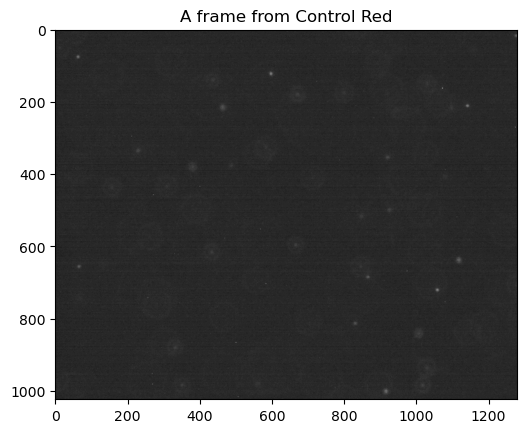

In [8]:
## Show a frame from each movie
if doing_fueled and colorseparation:
    plt.figure()
    plt.imshow(fueled_green[50], cmap='gray')
    plt.title('A frame from Fueled Green')
    
if doing_fueled:
    plt.figure()
    plt.imshow(fueled_red[50], cmap='gray')
    plt.title('A frame from Fueled Red')
    
if doing_control and colorseparation:
    plt.figure()
    plt.imshow(control_green[50], cmap='gray')
    plt.title('A frame from Control Green')
    
if doing_control:
    plt.figure()
    plt.imshow(control_red[50], cmap='gray')
    plt.title('A frame from Control Red')

# Test finding bright spots in ONE frame
You will probably need to adjust settings to use this properly.

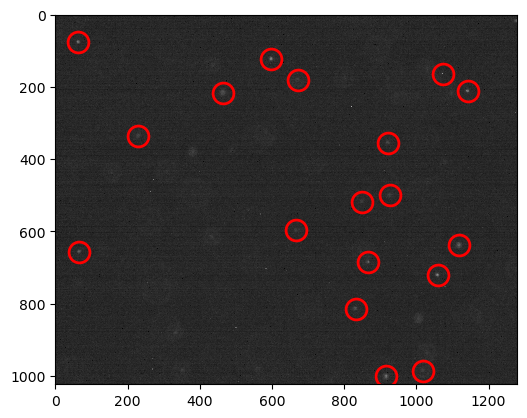

C:\Users\sarac\anaconda3\Lib\site-packages\trackpy\plots.py:638: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  axlist = f[pos_columns].applymap(lambda x: x % 1).hist()


array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'y'}>]],
      dtype=object)

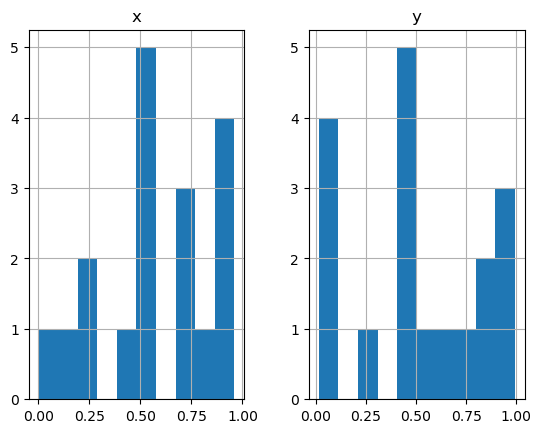

In [9]:
# Find bright spots in a frame of Fueled Green.
# featuresize must be odd.
# Read up on this in the trackpy literature.
# You need to update this if the particle, objective, or camera changes!!

i = 50 # Frame to search in
bright_background = False # Only true if looking for dark spots on a bright background
feature_size = 15 # Change this to find different size particles, can use ImageJ to get approximate feature size?
feature_mass_green = 375
feature_mass_red = 120
thresh = 0

if doing_control:
    f1 = tp.locate(control_red[i], diameter=feature_size, invert=bright_background, minmass=feature_mass_red, threshold=thresh)
else:
    f1 = tp.locate(fueled_green[i], diameter=feature_size, invert=bright_background, minmass=feature_mass_green, threshold=thresh)

plt.figure()  # make a new figure
if doing_control:
    tp.annotate(f1, control_red[i])
else:
    tp.annotate(f1, fueled_green[i])

tp.subpx_bias(f1)  # for determining if particles bias a pixel (you can check before doing the whole batch)

#del f1

# Find bright spots in ALL frames (slow)

In [10]:
# Now that we have picked out an appropriate featuresize and settings, it's time to go through ALL the frames,
# finding the coordinates of the bright spots in each frame.
# batch already uses a loop to go through frames

time_sec_1 = time.time()
# Elapsed time 1.4 min

In [11]:
if doing_fueled:
    fueled_tracer_coords = tp.batch(fueled_red, diameter=feature_size, invert=bright_background, minmass=feature_mass_red, threshold=thresh)
    tp.subpx_bias(fueled_tracer_coords)

In [12]:
if doing_fueled and  colorseparation:
    fueled_janus_coords = tp.batch(fueled_green, diameter=feature_size, invert=bright_background, minmass=feature_mass_green, threshold=thresh)
    tp.subpx_bias(fueled_janus_coords)
elif doing_fueled:
    fueled_janus_coords = fueled_tracer_coords

## Check tracking (especially featuresize) using subpixel biax

Frame 905: 27 features


C:\Users\sarac\anaconda3\Lib\site-packages\trackpy\plots.py:638: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  axlist = f[pos_columns].applymap(lambda x: x % 1).hist()


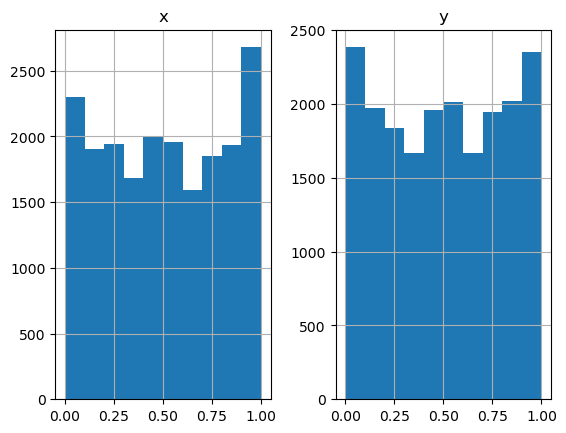

In [13]:
if doing_control:
    try:
        control_tracer_coords = tp.batch(control_red, diameter=feature_size, invert=bright_background, minmass=feature_mass_red, threshold=thresh)
    except ValueError as ve:
        print('Might have had issues with multiple processors. Repeating on just one processor.')
        control_tracer_coords = tp.batch(control_red, diameter=feature_size, invert=bright_background, 
                                         minmass=feature_mass_red, processes=1, threshold=thresh)
    tp.subpx_bias(control_tracer_coords)

In [14]:
if doing_control and  colorseparation:
    try:
        control_janus_coords = tp.batch(control_green, diameter=feature_size, invert=bright_background, minmass=feature_mass_green, threshold=thresh)
    except ValueError as ve:
        print('Might have had issues with multiple processors. Repeating on just one processor.')
        print(ve)
        control_janus_coords = tp.batch(control_green, diameter=feature_size, invert=bright_background, 
                                        minmass=feature_mass_green, processes=1, threshold=thresh)
    tp.subpx_bias(control_janus_coords)
elif doing_control:
    control_janus_coords = control_tracer_coords

In [15]:
 
time_sec_2 = time.time()
elapsed_min = (time_sec_2-time_sec_1)/60.0
print("Elapsed time " + str(elapsed_min) + " min" )

# Documentation: http://soft-matter.github.io/trackpy/generated/trackpy.batch.html

# This is an implementation of the Crocker-Grier centroid-finding algorithm.
#  Crocker, J.C., Grier, D.G. http://dx.doi.org/10.1006/jcis.1996.0217

Elapsed time 0.9202396273612976 min


In [16]:
# Note: These particle numbers count each frame individually, not the trajectories.
if doing_fueled:
    if colorseparation:
        print('Fueled Janus')
        print('Number of Frames: ' + str(len(fueled_green)))
        print('Number of Particles * Frames: ' + str(len(fueled_janus_coords)))
        print()
    print('Fueled Tracer')
    print('Number of Frames: ' + str(len(fueled_red)))
    print('Number of Particles * Frames: ' + str(len(fueled_tracer_coords)))
    print()
if doing_control:
    if colorseparation:
        print('Control Janus')
        print('Number of Frames: ' + str(len(control_green)))
        print('Number of Particles * Frames: ' + str(len(control_janus_coords)))
        print()
    print('Control Tracer')
    print('Number of Frames: ' + str(len(control_red)))
    print('Number of Particles * Frames: ' + str(len(control_tracer_coords)))

Control Tracer
Number of Frames: 906
Number of Particles * Frames: 19833


In [17]:
#filter out low mass high ecc

if filter_lowmass_highecc==True:
  filtered_control_tracer_coords=pd.DataFrame()
  highmass=control_tracer_coords[control_tracer_coords['mass']>800]
  filtered_control_tracer_coords=pd.concat([filtered_control_tracer_coords,highmass])
  lowmass=(control_tracer_coords[control_tracer_coords['mass'] < 800])
  lowmasslowecc=lowmass[lowmass['ecc'] < 0.2]
  filtered_control_tracer_coords=pd.concat([filtered_control_tracer_coords,lowmasslowecc])
  control_tracer_coords=filtered_control_tracer_coords


# Link Trajectories

In [18]:
# We have just built a list of coordinates called f_coords where we have seen particles. '
# Now we want to link these together from one frame to the next 
# so we can identify the trajectory for each particle.

# Documentation: http://soft-matter.github.io/trackpy/v0.3.0/generated/trackpy.link.html

# Fastest particle velocity observed in Viva's EPJST paper was about 15 microns/sec. Search
# range should be scalable based on that upper bound.
fastest = 15 # microns / second
memory = 5
search_range = int(round(fastest/(fps * scaling)))


print('Linking trajectories from one frame to the next with a memory of', memory, 'frames.')
if doing_fueled:
    if colorseparation:
        fueled_janus_unfiltered = tp.link_df(f=fueled_janus_coords, search_range=search_range, memory=memory)
    fueled_tracer_unfiltered = tp.link_df(f=fueled_tracer_coords, search_range=search_range, memory=memory)
if doing_control:
    if colorseparation:
        control_janus_unfiltered = tp.link_df(f=control_janus_coords, search_range=search_range, memory=memory)
    control_tracer_unfiltered = tp.link_df(f=control_tracer_coords, search_range=search_range, memory=memory)
"""
if doing_fueled:
    del fueled_janus_coords, fueled_tracer_coords
if doing_control:
    del control_janus_coords, control_tracer_coords
"""
if doing_fueled:
    if colorseparation:
        fueled_janus_unfiltered.to_pickle(movie_analysis_folder + 'fueled_janus_unfiltered.pkl')
    fueled_tracer_unfiltered.to_pickle(movie_analysis_folder + 'fueled_tracer_unfiltered.pkl')
if doing_control:
    if colorseparation:
        control_janus_unfiltered.to_pickle(movie_analysis_folder + 'control_janus_unfiltered.pkl')
    control_tracer_unfiltered.to_pickle(movie_analysis_folder + 'control_tracer_unfiltered.pkl')

print("The search range was {0} pixels.".format(search_range))

Frame 905: 26 trajectories present.
The search range was 2 pixels.


Trajectories before filtering
Control Tracer


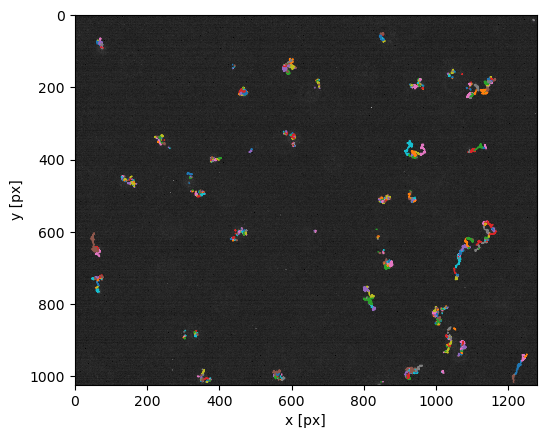

In [19]:
## Plot unfiltered trajectories

if do_slow_stuff:
    print('Trajectories before filtering')
    if doing_fueled:
        if colorseparation:
            print('Fueled Janus')
            fueled_janus_trajectory_plot = tp.plot_traj(fueled_janus_unfiltered,
                                           superimpose = fueled_green[int(len(fueled_green)/2)], label=False)

        print('Fueled Tracer')
        fueled_tracer_trajectory_plot = tp.plot_traj(fueled_tracer_unfiltered,
                                       superimpose = fueled_red[int(len(fueled_red)/2)], label=False)

    if doing_control:
        if colorseparation:
            print('Control Janus')
            control_janus_trajectory_plot = tp.plot_traj(control_janus_unfiltered,
                                           superimpose = control_green[int(len(control_green)/2)], label=False)

        print('Control Tracer')
        control_tracer_trajectory_plot = tp.plot_traj(control_tracer_unfiltered,
                                       superimpose = control_red[int(len(control_red)/2)], label=False)

# Filter trajectories by length

In [20]:
# Only keep trajectories that last at least this many frames
filter_length = 10
print('Filtering out trajectories that disappear before', filter_length, 'frames.')

if doing_fueled:
    fueled_tracer = tp.filter_stubs(fueled_tracer_unfiltered, filter_length)
    if colorseparation:
        fueled_janus = tp.filter_stubs(fueled_janus_unfiltered, filter_length)
    else:
        fueled_janus = fueled_tracer
if doing_control:
    control_tracer = tp.filter_stubs(control_tracer_unfiltered, filter_length)
    if colorseparation:
        control_janus = tp.filter_stubs(control_janus_unfiltered, filter_length)
    else:
        control_janus = control_tracer

## Save the trajectories
if doing_fueled:
    if colorseparation:
        fueled_janus.to_pickle(movie_analysis_folder + 'fueled_janus.pkl')
    fueled_tracer.to_pickle(movie_analysis_folder + 'fueled_tracer.pkl')
if doing_control:
    if colorseparation:
        control_janus.to_pickle(movie_analysis_folder + 'control_janus.pkl')
    control_tracer.to_pickle(movie_analysis_folder + 'control_tracer.pkl')

# Compare the number of particles in the unfiltered and filtered data.
if doing_fueled:
    if colorseparation:
        print('Fueled Janus')
        print('Before:', fueled_janus_unfiltered['particle'].nunique())
        print('After:', fueled_janus['particle'].nunique())
        metric4_fueled_janus = fueled_janus['particle'].nunique()
        print()
    print('Fueled Tracer')
    print('Before:', fueled_tracer_unfiltered['particle'].nunique())
    print('After:', fueled_tracer['particle'].nunique())
    metric4_fueled_tracer = fueled_tracer['particle'].nunique()
    print()
if doing_control:
    if colorseparation:
        print('Control Janus')
        print('Before:', control_janus_unfiltered['particle'].nunique())
        print('After:', control_janus['particle'].nunique())
        metric4_control_janus = control_janus['particle'].nunique()
        print()
    print('Control Tracer')
    print('Before:', control_tracer_unfiltered['particle'].nunique())
    print('After:', control_tracer['particle'].nunique())
    metric4_control_tracer = control_tracer['particle'].nunique()

Filtering out trajectories that disappear before 10 frames.
Control Tracer
Before: 1150
After: 358


# Visualize trajectories

Control Tracer


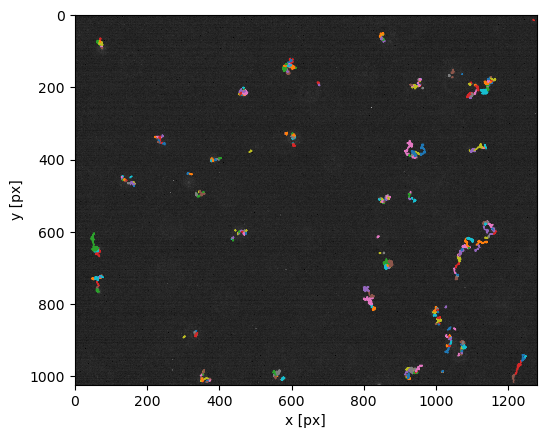

In [21]:
if do_slow_stuff:
    if doing_fueled:
        if colorseparation:
            print('Fueled Janus')
            fueled_janus_trajectory_plot = tp.plot_traj(fueled_janus,
                                           superimpose = fueled_green[int(len(fueled_green)/2)], label=False)

        print('Fueled Tracer')
        fueled_tracer_trajectory_plot = tp.plot_traj(fueled_tracer,
                                       superimpose = fueled_red[int(len(fueled_red)/2)], label=False)

    if doing_control:
        if colorseparation:
            print('Control Janus')
            control_janus_trajectory_plot = tp.plot_traj(control_janus,
                                           superimpose = control_green[int(len(control_green)/2)], label=False)

        print('Control Tracer')
        control_tracer_trajectory_plot = tp.plot_traj(control_tracer,
                                       superimpose = control_red[int(len(control_red)/2)], label=False)

Control Tracer


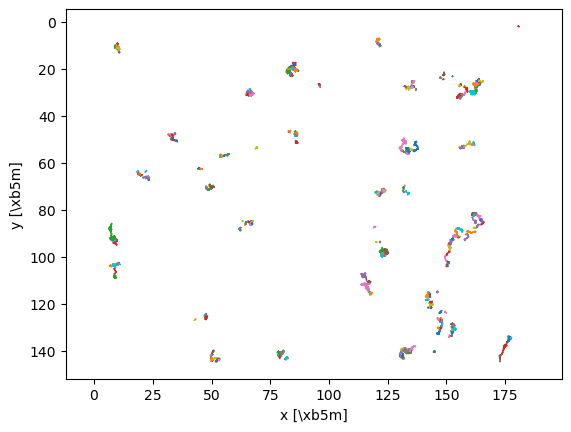

In [22]:
try:
    axes().set_aspect('equal', 'datalim') 
except:
    pass

if do_slow_stuff:
    if doing_fueled:
        if colorseparation:
            print('Fueled Janus')
            plt.axis('equal')
            fueled_janus_trajectory_plot = tp.plot_traj(fueled_janus, mpp=scaling)

        print('Fueled Tracer')
        plt.axis('equal')
        fueled_tracer_trajectory_plot = tp.plot_traj(fueled_tracer, mpp=scaling)

    if doing_control:
        if colorseparation:
            print('Control Janus')
            plt.axis('equal')
            control_janus_trajectory_plot = tp.plot_traj(control_janus, mpp=scaling)

        print('Control Tracer')
        plt.axis('equal')
        control_tracer_trajectory_plot = tp.plot_traj(control_tracer, mpp=scaling)

# Check Tracking

Check that a particle is the object being tracked in each of the following:


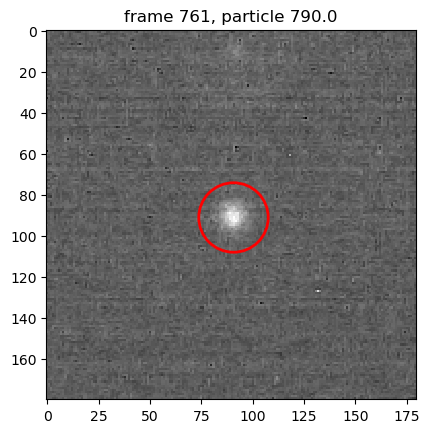

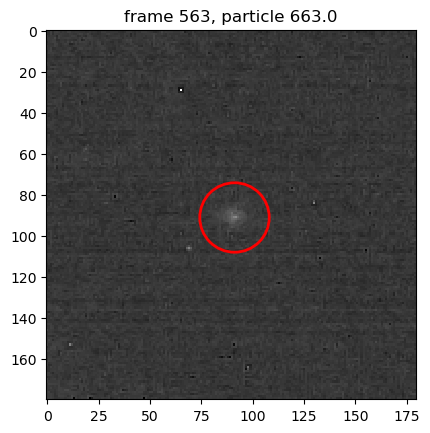

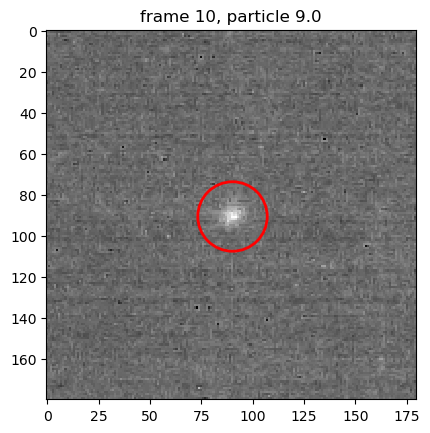

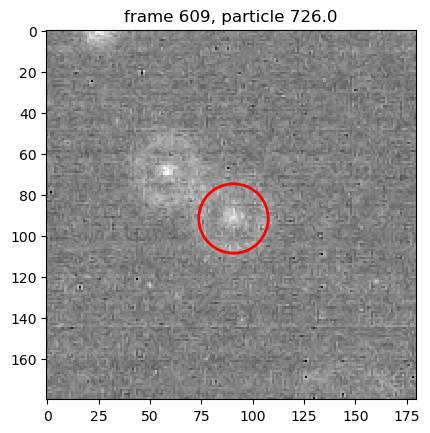

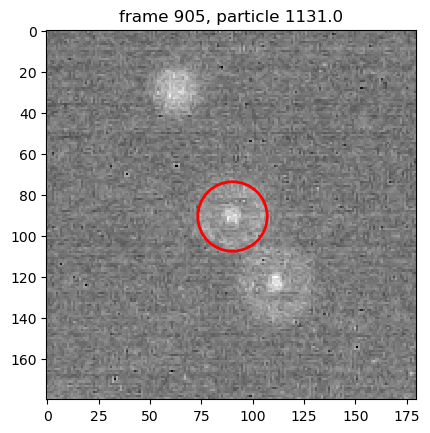

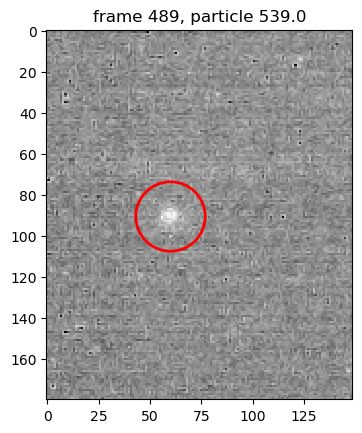

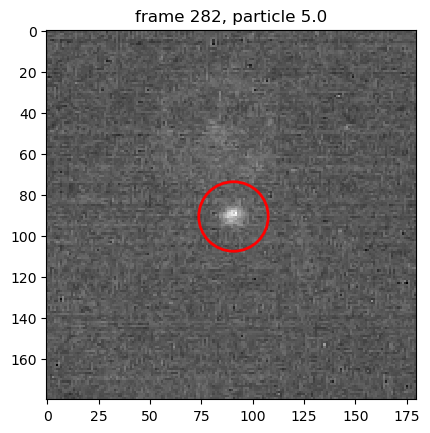

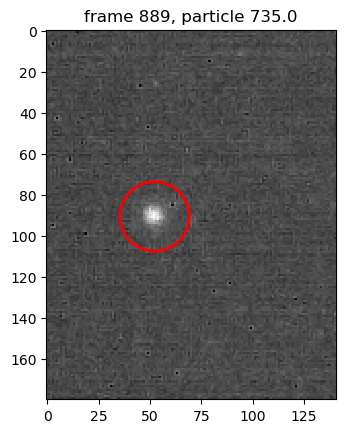

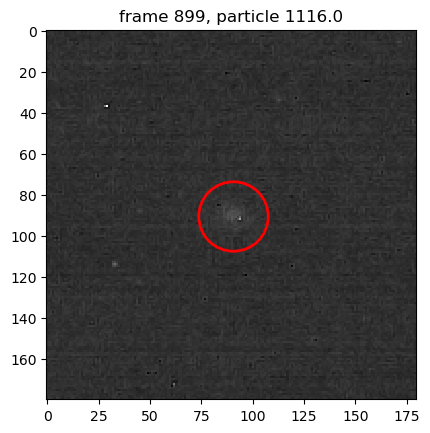

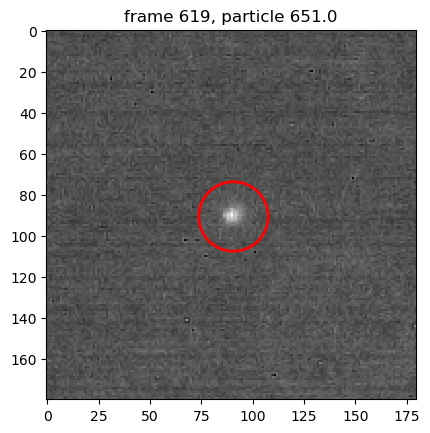

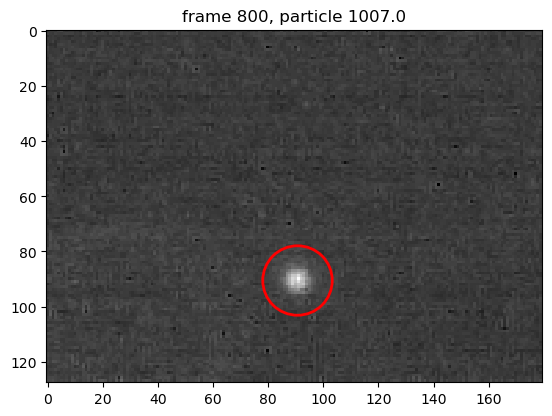

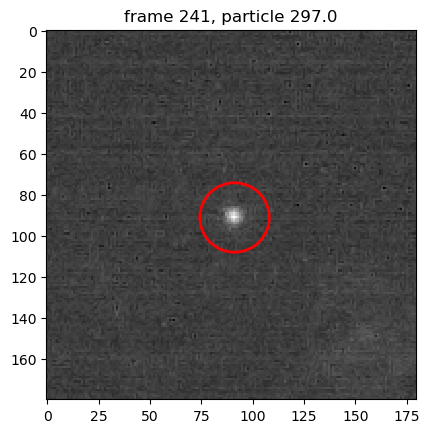

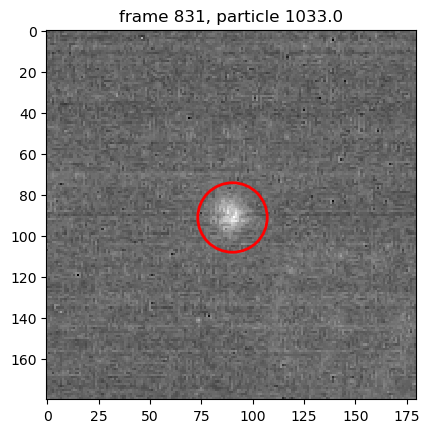

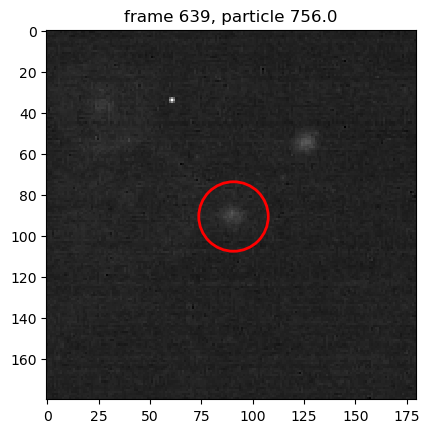

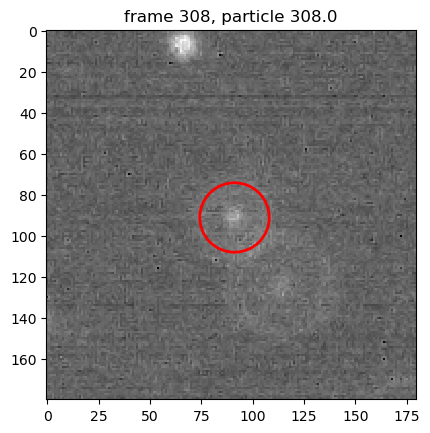

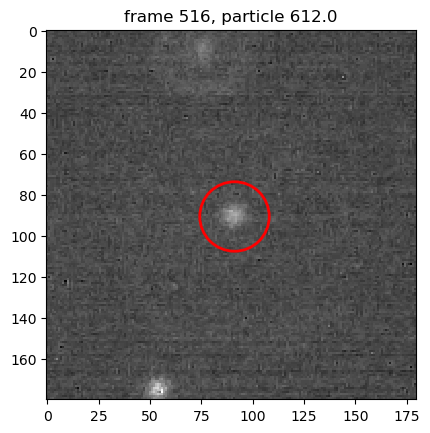

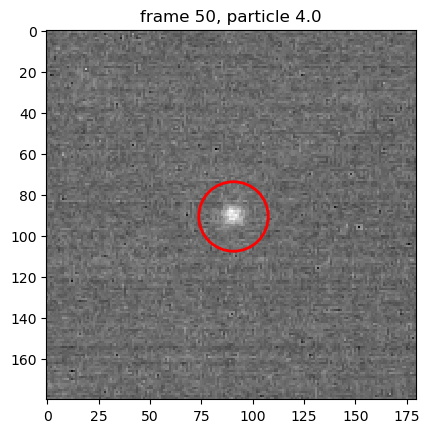

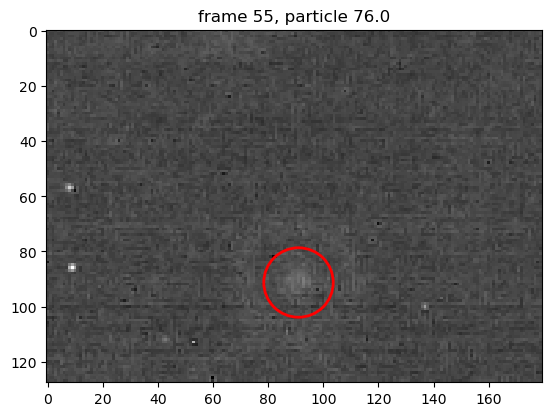

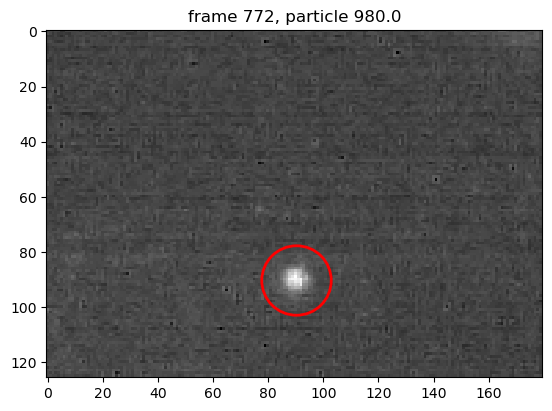

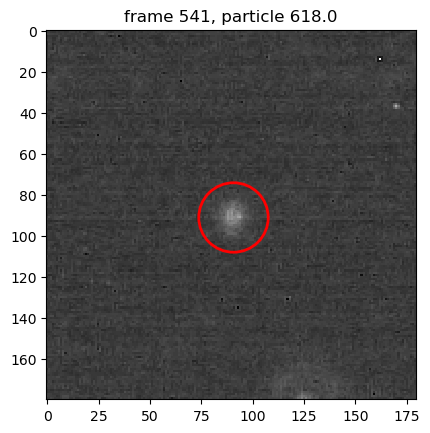

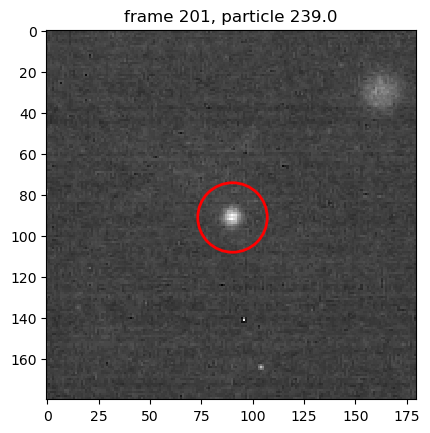

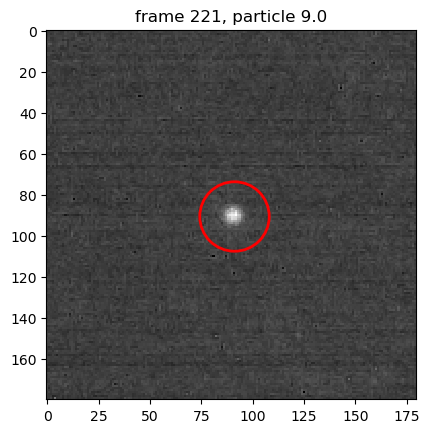

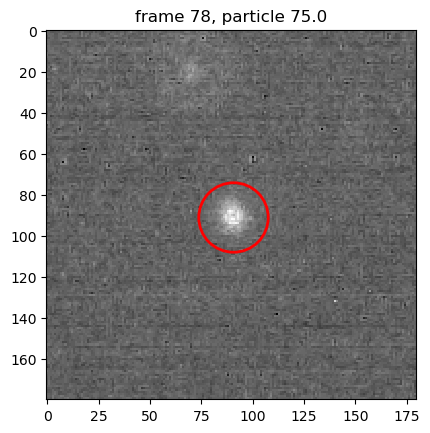

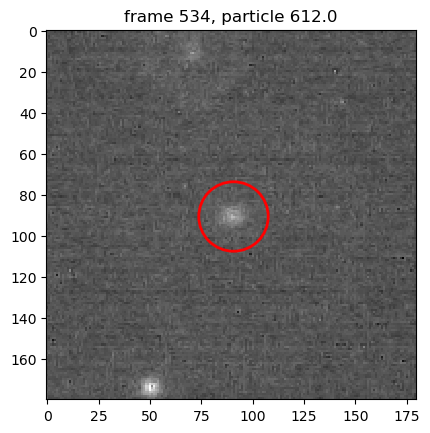

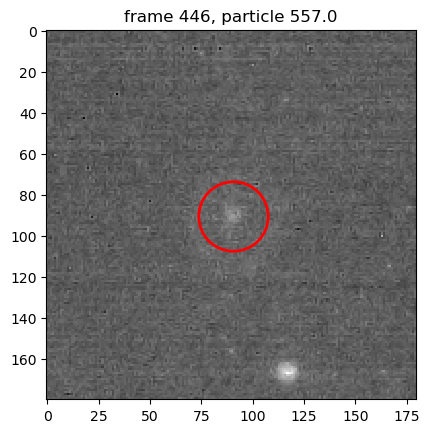

In [23]:

print("Check that a particle is the object being tracked in each of the following:")



# Image cropping! We need to see if tracking is working, so we need to zoom in on a few particles
view_number = 25 # number of particles to view here

import random
# pick a few random particles. You can re-run this cell to select more.
rows = random.sample(range(0, len(control_tracer_coords)), view_number)

# The full image is 1024 rows x 1280 columns 
# set width of image to display
width = 180 # width of image to display. 
# 180 is good for zooming in
# 600 is good for wider view (for context)
             
# edges() is a function for how to calculate the edges of a cropped image so we can zoom in.                     
def edges(x,y,width):
    xlow = int(max(0, x-width/2)) # edges for cropping the image. Don't go below 0!
    xhigh = int(x+width/2) # the upper edge
    ylow = int(max(0,y-width/2))
    yhigh = int(y+width/2)

    # subtract low edges to re-center coordinates
    coords = pd.DataFrame({'x': [x-xlow], 'y': [y-ylow]})  # x: horizontal, y: vertical
    return xlow,xhigh,ylow,yhigh, coords
                     
for row in rows:
    x = control_tracer_unfiltered.iloc[row].x
    y = control_tracer_unfiltered.iloc[row].y # pick out one particle x and y coordinates.

    xlow,xhigh,ylow,yhigh, coords = edges(x,y,width)
    
    i = control_tracer_unfiltered.iloc[row].frame

    plt.figure()
    plt.title('frame ' + str(int(i)) + ', particle ' + str(control_tracer_unfiltered.iloc[row].particle))
    tp.annotate(centroids = coords, 
                image = control_red[i][ylow:yhigh, xlow:xhigh],  # or I could have used extent = np.min(x), np.max(x), np.min(y), np.max(y) 
                plot_style={'markersize': 50} ); # size 2 or 50 is good


# Drift Subtraction

Conducting drift subtraction.
Elapsed time 0.3161589026451111 min


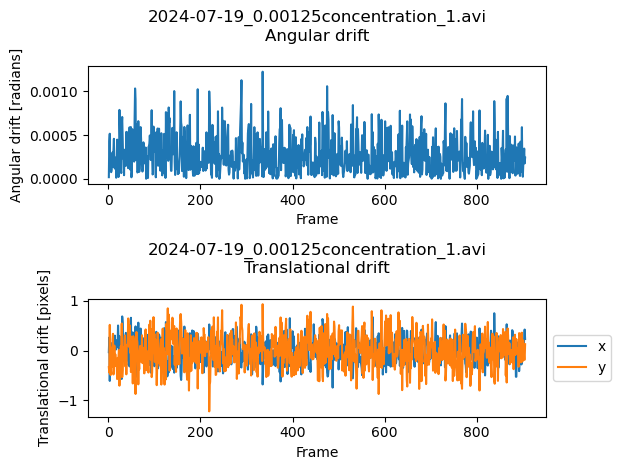

In [24]:
time_sec_3 = time.time()
# Elapsed time 0.3 min

# Conduct rotational drift subtraction.

print('Conducting drift subtraction.')
if doing_fueled:
    fueled_janus_nodrift, fueled_tracer_nodrift = drift_subtract(fueled_janus, fueled_tracer)
    if not colorseparation:
        fueled_janus_nodrift = fueled_tracer_nodrift
    colorseparation=colorseparation
if doing_control:
    control_janus_nodrift, control_tracer_nodrift = drift_subtract(control_janus, control_tracer)
    if not colorseparation:
        control_janus_nodrift = control_tracer_nodrift


time_sec_4 = time.time()
elapsed_min = (time_sec_4-time_sec_3)/60.0
print("Elapsed time " + str(elapsed_min) + " min" )
    
if doing_fueled:
    if colorseparation:
        fueled_janus_nodrift.to_pickle(movie_analysis_folder + 'fueled_janus_nodrift.pkl')
    fueled_tracer_nodrift.to_pickle(movie_analysis_folder + 'fueled_tracer_nodrift.pkl')
if doing_control:
    if colorseparation:
        control_janus_nodrift.to_pickle(movie_analysis_folder + 'control_janus_nodrift.pkl')
    control_tracer_nodrift.to_pickle(movie_analysis_folder + 'control_tracer_nodrift.pkl')
    
plt.tight_layout()

The maximum drift (in um) in x and y was:


y    3.833026
x    1.702148
dtype: float64

<Figure size 640x480 with 0 Axes>

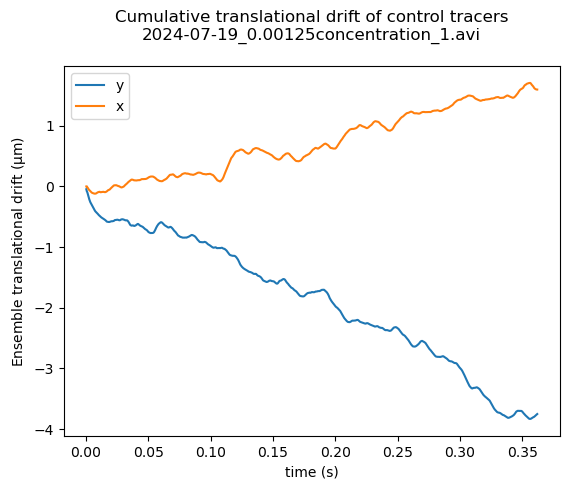

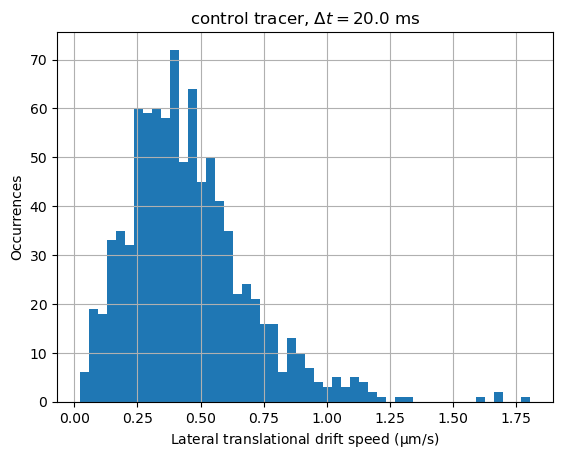

In [25]:
## View translational drift (though we use rotational drift for drift
## subtraction)
smoothing = 15 # frames

if doing_control:
    drift_control_tracer = tp.compute_drift(control_tracer, smoothing)*scaling
    if colorseparation:
        drift_control_janus = tp.compute_drift(control_janus, smoothing)*scaling
    else:
        drift_control_janus = drift_control_tracer

    # Convert from frames to seconds
    drift_control_janus.index = drift_control_janus.index /fps
    drift_control_tracer.index = drift_control_tracer.index /fps
    drift_control_janus.index.name = 'time (s)'
    drift_control_tracer.index.name = 'time (s)'

    if colorseparation:
        plt.figure()
        drift_control_janus.plot(grid=False)
        plt.title('Cumulative translational drift of control Janus\n' + movie_name + '\n')
        plt.ylabel('Ensemble translational drift ($\mathrm{\mu}$m)')
        #plt.xlabel('seconds')

    plt.figure()
    drift_control_tracer.plot(grid=False)
    plt.title('Cumulative translational drift of control tracers\n' + movie_name + '\n')
    plt.ylabel('Ensemble translational drift ($\mathrm{\mu}$m)')

    if colorseparation:
        motion_control_janus = drift_control_janus.diff()
        velocity_control_janus_df = (drift_control_janus.diff()/ (1/fps))
        velocity_control_janus_df.plot()
        plt.ylabel("Control Janus ensemble mean velocity ($\mathrm{\mu}$m/s)")
        plt.title('Smoothing: ' + str(smoothing) + " frames")


    motion_control_tracer = drift_control_tracer.diff()
    velocity_control_tracer_df = (drift_control_tracer.diff()/ (1/fps))
    if colorseparation:
        velocity_control_tracer_df.plot()
        plt.ylabel("Control tracer ensemble mean velocity ($\mathrm{\mu}$m/s)")
        plt.title('Smoothing: ' + str(smoothing) + " frames")

    ## Add speed to dataframes
    if colorseparation:
        velocity_control_janus_df['speed'] = sqrt(velocity_control_janus_df.x**2 + velocity_control_janus_df.y**2)
    velocity_control_tracer_df['speed'] = sqrt(velocity_control_tracer_df.x**2 + velocity_control_tracer_df.y**2)

    if colorseparation:
        plt.figure()
        velocity_control_janus_df.speed.hist(bins=50, label="control janus")
        plt.xlabel("Lateral translational drift speed ($\mathrm{\mu}$m/s)")
        plt.ylabel("Occurrences")
        plt.title("control janus")

    plt.figure()
    velocity_control_tracer_df.speed.hist(bins=50, label="control tracer")
    plt.xlabel("Lateral translational drift speed ($\mathrm{\mu}$m/s)")
    plt.ylabel("Occurrences")
    plt.title( "control tracer, $\Delta t =$" + str(frametime) + ' ms' )
    
    max_cartesian_drift_control_tracer_um = max(abs(drift_control_tracer).max())
    print('The maximum drift (in um) in x and y was:')
    display(abs(drift_control_tracer).max() );

if doing_fueled:
    drift_fueled_janus = tp.compute_drift(fueled_janus, smoothing)*scaling
    drift_fueled_tracer = tp.compute_drift(fueled_tracer, smoothing)*scaling

    # Convert from frames to seconds
    drift_fueled_janus.index = drift_fueled_janus.index /fps
    drift_fueled_tracer.index = drift_fueled_tracer.index /fps
    drift_fueled_janus.index.name = 'time (s)'
    drift_fueled_tracer.index.name = 'time (s)'

    plt.figure()
    drift_fueled_janus.plot(grid=False)
    plt.title('Translational drift of fueled Janus\n' + movie_name + '\n')
    plt.ylabel('Ensemble translational drift ($\mathrm{\mu}$m)')

    plt.figure()
    drift_fueled_tracer.plot(grid=False)
    plt.title('Translational drift of fueled tracers\n' + movie_name + '\n')
    plt.ylabel('Ensemble translational drift ($\mathrm{\mu}$m)')

    motion_fueled_janus = drift_fueled_janus.diff()
    velocity_fueled_janus_df = (drift_fueled_janus.diff()/ (1/fps))
    velocity_fueled_janus_df.plot()
    plt.ylabel("fueled Janus ensemble mean velocity ($\mathrm{\mu}$m/s)")
    plt.title('Smoothing: ' + str(smoothing) + " frames")

    motion_fueled_tracer = drift_fueled_tracer.diff()
    velocity_fueled_tracer_df = (drift_fueled_tracer.diff()/ (1/fps))
    velocity_fueled_tracer_df.plot()
    plt.ylabel("fueled tracer ensemble mean velocity ($\mathrm{\mu}$m/s)")
    plt.title('Smoothing: ' + str(smoothing) + " frames")

    ## Add speed to dataframes
    velocity_fueled_janus_df['speed'] = sqrt(velocity_fueled_janus_df.x**2 + velocity_fueled_janus_df.y**2)
    velocity_fueled_tracer_df['speed'] = sqrt(velocity_fueled_tracer_df.x**2 + velocity_fueled_tracer_df.y**2)

    plt.figure()
    velocity_fueled_janus_df.speed.hist(bins=50, label="fueled janus")
    plt.xlabel("Lateral translational drift speed ($\mathrm{\mu}$m/s)")
    plt.ylabel("Occurrences")
    plt.title("fueled janus")

    plt.figure()
    velocity_fueled_tracer_df.speed.hist(bins=50, label="fueled tracer")
    plt.xlabel("Lateral translational drift speed ($\mathrm{\mu}$m/s)")
    plt.ylabel("Occurrences")
    plt.title("fueled tracer")

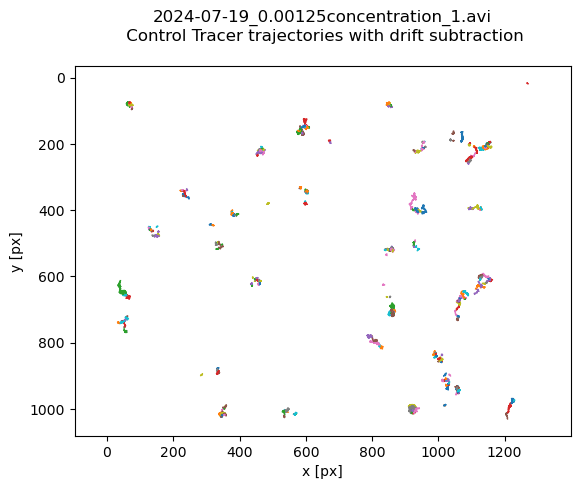

In [26]:
if do_slow_stuff:
    if doing_fueled:
        plt.axis('equal')
        plt.title(movie_name + '\n Fueled Janus trajectories with drift subtraction\n')
        ax = tp.plot_traj(fueled_janus_nodrift, legend=False)

    if doing_fueled:
        plt.axis('equal')
        plt.title(movie_name + '\n Fueled Tracer trajectories with drift subtraction\n')
        ax = tp.plot_traj(fueled_tracer_nodrift, legend=False)

    if doing_control and colorseparation:
        plt.axis('equal')
        plt.title(movie_name + '\n Control Janus trajectories with drift subtraction\n')
        ax = tp.plot_traj(control_janus_nodrift, legend=False)

    if doing_control:
        plt.axis('equal')
        plt.title(movie_name + '\n Control Tracer trajectories with drift subtraction\n')
        ax = tp.plot_traj(control_tracer_nodrift, legend=False)

# Calculate MSDs

In [27]:
start = time.time()

if doing_fueled:
    fueled_janus_imsd = tp.imsd(fueled_janus_nodrift, mpp=scaling, fps=fps, max_lagtime=1000)
    fueled_tracer_imsd = tp.imsd(fueled_tracer_nodrift, mpp=scaling, fps=fps, max_lagtime=1000)
if doing_control:
    control_janus_imsd = tp.imsd(control_janus_nodrift, mpp=scaling, fps=fps, max_lagtime=1000)
    control_tracer_imsd = tp.imsd(control_tracer_nodrift, mpp=scaling, fps=fps, max_lagtime=1000)
    
end = time.time()
    
print('Calculating iMSD took', end-start, 'sec.')

Calculating iMSD took 1.9469192028045654 sec.


It's normal for this to look messy for random motion.


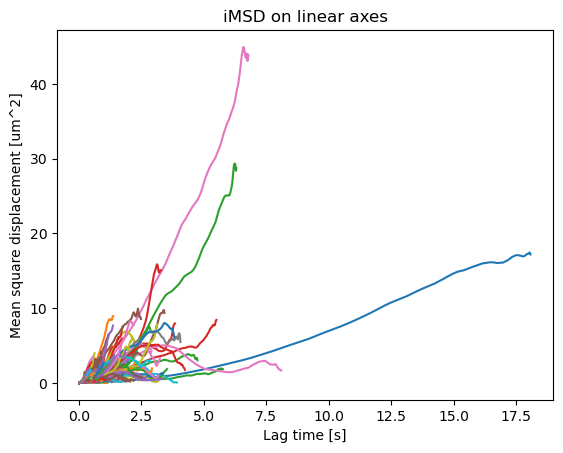

In [28]:
control_tracer_imsd.replace(0, np.nan, inplace=True)
plt.plot(control_tracer_imsd);
plt.ylabel("Mean square displacement [um^2]");
plt.xlabel("Lag time [s]");
plt.title('iMSD on linear axes')

print("It's normal for this to look messy for random motion.")

In [29]:
if colorseparation:
    fig, ax = plt.subplots()
    if doing_fueled:
        plt.plot(fueled_janus_imsd, 'r-', alpha=0.15)
    if doing_control:
        plt.plot(control_janus_imsd, '.', alpha=0.05)

    ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
           xlabel='lag time $\Delta{}t$ [s]')
    ax.set_xscale('log')
    ax.set_yscale('log')
    fig.set_size_inches(3,3)
    plt.title(movie_name + '\nJanus iMSD, drift-subtracted');

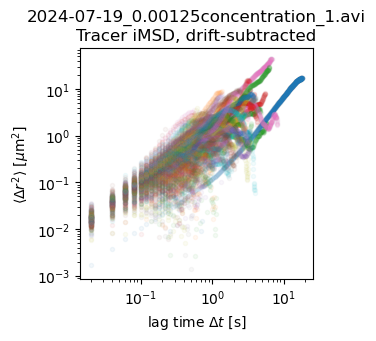

In [30]:
fig, ax = plt.subplots()
if doing_fueled:
    ax.plot(fueled_tracer_imsd, 'r-', alpha=0.15)
if doing_control:
    ax.plot(control_tracer_imsd, '.', alpha=0.05)

ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $\Delta{}t$ [s]')
ax.set_xscale('log')
ax.set_yscale('log')
fig.set_size_inches(3,3)
plt.title(movie_name + '\nTracer iMSD, drift-subtracted');

In [31]:
if doing_fueled:
    fueled_janus_imsd_drifty = tp.imsd(fueled_janus, mpp=scaling, fps=fps, max_lagtime=1000)
    fueled_tracer_imsd_drifty = tp.imsd(fueled_tracer, mpp=scaling, fps=fps, max_lagtime=1000)
if doing_control:
    control_janus_imsd_drifty = tp.imsd(control_janus, mpp=scaling, fps=fps, max_lagtime=1000)
    control_tracer_imsd_drifty = tp.imsd(control_tracer, mpp=scaling, fps=fps, max_lagtime=1000)

In [32]:
if colorseparation:
    fig, ax = plt.subplots()
    if doing_fueled:
        ax.plot(fueled_janus_imsd_drifty, 'r-', alpha=0.15)
    if doing_control:
        ax.plot(control_janus_imsd_drifty, '.', alpha=0.05)

    ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
           xlabel='lag time $\Delta{}t$ [s]')
    ax.set_xscale('log')
    ax.set_yscale('log')
    fig.set_size_inches(3,3)
    plt.title(movie_name + '\nJanus iMSD, not drift-subtracted');

Tell Viva if there are two different populations.


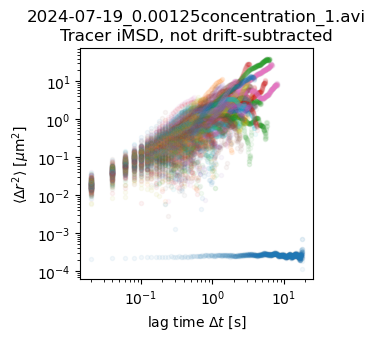

In [33]:
fig, ax = plt.subplots()
if doing_fueled:
    ax.plot(fueled_tracer_imsd_drifty, 'r-', alpha=0.15)
if doing_control:
    ax.plot(control_tracer_imsd_drifty, '.', alpha=0.05)

ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $\Delta{}t$ [s]')
ax.set_xscale('log')
ax.set_yscale('log')
fig.set_size_inches(3,3)
plt.title(movie_name + '\nTracer iMSD, not drift-subtracted');


print("Tell Viva if there are two different populations.")

## Calculate eMSDs

In [34]:
emsd_max_lagtime = 100
if doing_fueled:
    fueled_janus_emsd = tp.emsd(fueled_janus_nodrift, mpp=scaling, fps=fps, max_lagtime = emsd_max_lagtime).replace(0, np.nan).dropna()
    fueled_tracer_emsd = tp.emsd(fueled_tracer_nodrift, mpp=scaling, fps=fps, max_lagtime = emsd_max_lagtime).replace(0, np.nan).dropna()
if doing_control:
    control_janus_emsd = tp.emsd(control_janus_nodrift, mpp=scaling, fps=fps, max_lagtime = emsd_max_lagtime).replace(0, np.nan).dropna()
    control_tracer_emsd = tp.emsd(control_tracer_nodrift, mpp=scaling, fps=fps, max_lagtime = emsd_max_lagtime).replace(0, np.nan).dropna()

## Fit powerlaw to eMSD
### Filtering out static localization error at small displacements.

In [35]:
### Filter out small displacements from the curvefit.
threshold = 0.1 ## Might need to adjust this!

C:\Users\sarac\AppData\Local\Temp\ipykernel_18132\4136575606.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  control_tracer_fit_y = [control_tracer_fit.A[0] * np.power(control_tracer_fit_x[0], control_tracer_fit.n[0]),
C:\Users\sarac\AppData\Local\Temp\ipykernel_18132\4136575606.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  control_tracer_fit.A[0] * np.power(control_tracer_fit_x[1], control_tracer_fit.n[0])]


Saved:
 tracer_eMSDs.png


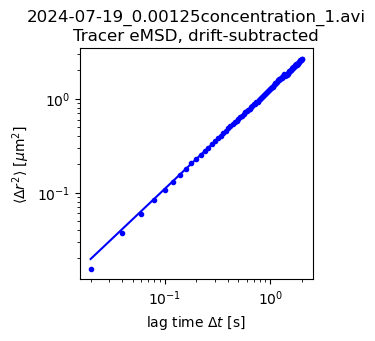

In [36]:
fig, ax1 = plt.subplots()

if doing_fueled:
    fueled_tracer_emsd_filtered = fueled_tracer_emsd[fueled_tracer_emsd >= threshold]
    fueled_tracer_fit = tp.utils.fit_powerlaw(fueled_tracer_emsd_filtered, plot = False)
    
    # Displaying 2 points of the curvefit is sufficient because it appears as a straight line
    fueled_tracer_fit_x = [1/fps, (1/fps) * len(fueled_tracer_emsd)]
    fueled_tracer_fit_y = [fueled_tracer_fit.A[0] * np.power(fueled_tracer_fit_x[0], fueled_tracer_fit.n[0]),
                         fueled_tracer_fit.A[0] * np.power(fueled_tracer_fit_x[1], fueled_tracer_fit.n[0])]

if doing_control:
    control_tracer_emsd_filtered = control_tracer_emsd[control_tracer_emsd >= threshold]
    control_tracer_fit = tp.utils.fit_powerlaw(control_tracer_emsd_filtered, plot = False)
    
    # Displaying 2 points of the curvefit is sufficient because it appears as a straight line
    control_tracer_fit_x = [1/fps, (1/fps) * len(control_tracer_emsd)]
    control_tracer_fit_y = [control_tracer_fit.A[0] * np.power(control_tracer_fit_x[0], control_tracer_fit.n[0]),
                         control_tracer_fit.A[0] * np.power(control_tracer_fit_x[1], control_tracer_fit.n[0])]

if doing_fueled:
    fueled_tracer_emsd.plot(loglog=True, figsize = [3,3], style = 'r.',  grid=False, ax=ax1)
    plt.plot(fueled_tracer_fit_x, fueled_tracer_fit_y, 'r')

if doing_control:
    control_tracer_emsd.plot(loglog=True, figsize = [3,3], style = 'b.',  grid=False, ax=ax1)
    plt.plot(control_tracer_fit_x, control_tracer_fit_y, 'b')

ax1.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]', xlabel='lag time $\Delta{}t$ [s]')
plt.title(movie_name + '\nTracer eMSD, drift-subtracted')

savefigure('tracer_eMSDs')

In [37]:
if colorseparation:

    fig, ax1 = plt.subplots()


    if doing_fueled:
        fueled_janus_emsd_filtered = fueled_janus_emsd[fueled_janus_emsd >= threshold]
        fueled_janus_fit = tp.utils.fit_powerlaw(fueled_janus_emsd_filtered, plot = False)

        # Displaying 2 points of the curvefit is sufficient because it appears as a straight line
        fueled_janus_fit_x = [1/fps, (1/fps) * len(fueled_janus_emsd)]
        fueled_janus_fit_y = [fueled_janus_fit.A[0] * np.power(fueled_janus_fit_x[0], fueled_janus_fit.n[0]),
                             fueled_janus_fit.A[0] * np.power(fueled_janus_fit_x[1], fueled_janus_fit.n[0])]

    if doing_control:
        control_janus_emsd_filtered = control_janus_emsd[control_janus_emsd >= threshold]
        control_janus_fit = tp.utils.fit_powerlaw(control_janus_emsd_filtered, plot = False)

        # Displaying 2 points of the curvefit is sufficient because it appears as a straight line
        control_janus_fit_x = [1/fps, (1/fps) * len(control_janus_emsd)]
        control_janus_fit_y = [control_janus_fit.A[0] * np.power(control_janus_fit_x[0], control_janus_fit.n[0]),
                             control_janus_fit.A[0] * np.power(control_janus_fit_x[1], control_janus_fit.n[0])]

    if doing_fueled:
        fueled_janus_emsd.plot(loglog=True, figsize = [3,3], style = 'r.',  grid=False, ax=ax1)
        plt.plot(fueled_janus_fit_x, fueled_janus_fit_y, 'r')

    if doing_control:
        control_janus_emsd.plot(loglog=True, figsize = [3,3], style = 'b.',  grid=False, ax=ax1)
        plt.plot(control_janus_fit_x, control_janus_fit_y, 'b')

    ax1.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]', xlabel='lag time $\Delta{}t$ [s]')
    plt.title(movie_name + '\nJanus eMSD, drift-subtracted')

    savefigure('janus_eMSDs')

In [38]:
control_tracer_emsd.to_csv(os.path.join(movie_analysis_folder, movie_name + '.csv'))

Saved to: particle_eMSDsthresholded_fit
Saved:
 particle_eMSDsthresholded_fit.png


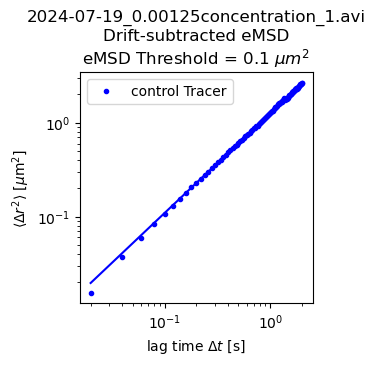

In [41]:
fig, ax1 = plt.subplots()

if colorseparation:
    if doing_fueled:
        fueled_janus_emsd.plot(loglog=True, figsize = [3,3], style = 'k.',  grid=False, ax=ax1, label="fueled Janus")
        plt.plot(fueled_janus_fit_x, fueled_janus_fit_y, 'k')

    if doing_control:
        control_janus_emsd.plot(loglog=True, figsize = [3,3], style = 'g.',  grid=False, ax=ax1, label="control Janus")
        plt.plot(control_janus_fit_x, control_janus_fit_y, 'g')

if doing_fueled:
    fueled_tracer_emsd.plot(loglog=True, figsize = [3,3], style = 'r.',  grid=False, ax=ax1, label="fueled Tracer")
    plt.plot(fueled_tracer_fit_x, fueled_tracer_fit_y, 'r')

if doing_control:
    control_tracer_emsd.plot(loglog=True, figsize = [3,3], style = 'b.',  grid=False, ax=ax1, label="control Tracer")
    plt.plot(control_tracer_fit_x, control_tracer_fit_y, 'b')

ax1.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]', xlabel='lag time $\Delta{}t$ [s]')
plt.title(movie_name + 
          '\nDrift-subtracted eMSD'+
          '\neMSD Threshold = ' + str(threshold) + r' $\mu m^2$')

plt.legend()


if colorseparation:
    savestr = 'janus+tracer'
else:
    savestr = 'particle'
    
savefile = savestr + '_eMSDsthresholded_fit'
print('Saved to:',savefile )

savefigure(savefile)


In [42]:
if doing_fueled:
    if colorseparation:
        print('Fueled Janus: n =', fueled_janus_fit.values[0,0], 'A =' , fueled_janus_fit.values[0,1])
    print('Fueled Tracers: n =', fueled_tracer_fit.values[0,0], 'A =' , fueled_tracer_fit.values[0,1])
if doing_control:
    if colorseparation:
        print('Control Janus: n =', control_janus_fit.values[0,0], 'A =' , control_janus_fit.values[0,1])
    print('Control Tracers: n =', control_tracer_fit.values[0,0], ', A =' , control_tracer_fit.values[0,1])

if doing_fueled:
    if colorseparation:
        fueled_janus_emsd.to_csv(os.path.join(movie_analysis_folder, "fueled_janus_emsd.csv"))
    fueled_tracer_emsd.to_csv(os.path.join(movie_analysis_folder, "fueled_janus_emsd.csv"))
if doing_control:
    if colorseparation:
        control_janus_emsd.to_csv(os.path.join(movie_analysis_folder, "fueled_janus_emsd.csv"))
    control_tracer_emsd.to_csv(os.path.join(movie_analysis_folder, "fueled_janus_emsd.csv"))

Control Tracers: n = 1.0649643949612195 , A = 1.2660023868720087


# Gamma calculation
## following Diego Krapf

Calculating gamma with particle trajectories longer than 300 frames
Using a minimum trajectory length of 300 frames, we analyze 4 particle trajectories.
Total video length: 18.1 sec


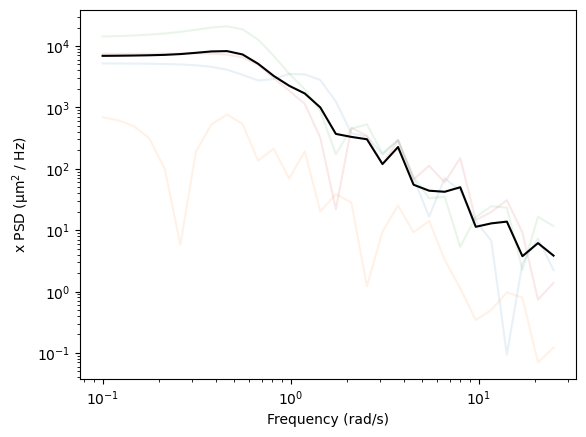

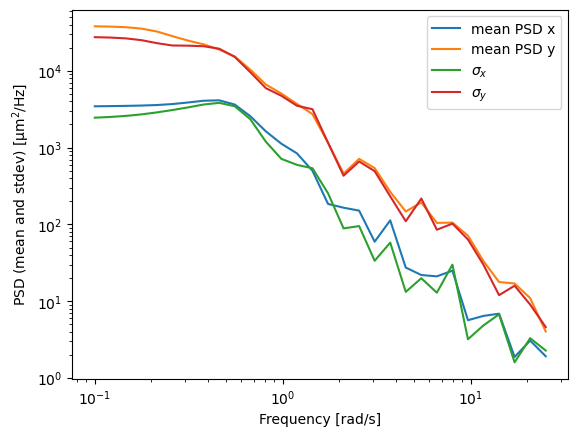

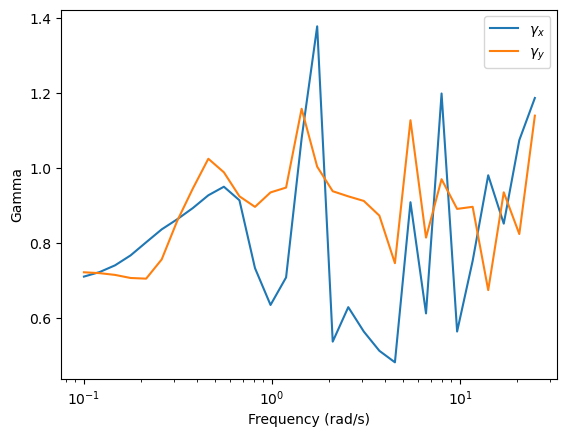

In [43]:
verbose = False
minimumlength = 300 # set to a number that retains a reasonable number of particle trajectories

# filter stubs to remove short trajectories.
df = tp.filter_stubs(control_tracer_nodrift, threshold=minimumlength)

print(r'Calculating gamma with particle trajectories longer than', minimumlength, 'frames')

freqs_rad_per_sec = np.logspace(-1, np.log10(fps/2), 30) # Use Nyquist frequency fps/2 as maximum

#particle = df.particle.values[0]
# print('Using a minimum trajectory length of', minimumlength, 'frames, we analyze', df.particle.nunique(), 'particle trajectories.')

print('Using a minimum trajectory length of', minimumlength, 'frames, we analyze', df.particle.nunique(), 'particle trajectories.')

#  initialize
Pxxes = np.zeros((len(freqs_rad_per_sec), df.particle.nunique()), dtype = "float64") 
Pyyes = np.zeros((len(freqs_rad_per_sec), df.particle.nunique()), dtype = "float64") 

if verbose:
    print("Initialized array of size:", (df.particle.nunique(), len(freqs_rad_per_sec)))

for (particle,reindex_particle) in zip(df.particle.unique(), range(df.particle.nunique())):
    x = ((df[df.particle == particle]).x)
    y = ((df[df.particle == particle]).y)    
    xminusx0 = x - x.values[0]
    yminusy0 = y - y.values[0]
    frames = x.index.astype(int)
    #fps = combined_df.fps[i]
    times_in_sec = frames/fps

    # Calculate Probability Spectral Density for data with missing times.
    Pxx_den = scipy.signal.lombscargle(times_in_sec, xminusx0, freqs_rad_per_sec)
    Pyy_den = scipy.signal.lombscargle(times_in_sec, yminusy0, freqs_rad_per_sec)

    
    plt.loglog(freqs_rad_per_sec, Pxx_den,alpha = .1 )

    if verbose:
        print('Particle', particle, 'reindexed as', reindex_particle)
        print('length of samples:', len(xminusx0))
        display(x)
        print('Pxx_den:',Pxx_den)
    Pxxes[:, reindex_particle] = Pxx_den
    Pyyes[:, reindex_particle] = Pyy_den

    
plt.loglog(freqs_rad_per_sec, np.mean(Pxxes, axis=1), 'k')
#plt.ylim(-1, 250)
plt.xlabel("Frequency (rad/s)")
plt.ylabel("x PSD ($\mathrm{\mu}$m$^2$ / Hz)")
#plt.title(combined_df['control_tracer.pkl'].values[i]);
#plt.title('suspected subdiffusion')


# Convert 2-sided to 1-sided psd
pxx = Pxxes / 2
pyy = Pyyes / 2

# Calculate gamma
sigmax = np.std(pxx, axis=1) # standard deviation across many particle trajectories
mux = np.mean(pxx, axis=1)
gammax = sigmax / mux  # standard deviation / mean of PSD, as a function of frequency.

sigmay = np.std(pyy, axis=1)
muy = np.mean(pyy, axis=1)
gammay = sigmay / muy 

plt.figure()
plt.loglog(freqs_rad_per_sec, mux, label = r"mean PSD x")
plt.loglog(freqs_rad_per_sec, muy, label = r"mean PSD y")


plt.loglog(freqs_rad_per_sec, sigmax, label = r"$\sigma_x$")
plt.loglog(freqs_rad_per_sec, sigmay, label = r"$\sigma_y$")
plt.legend()
plt.xlabel('Frequency [rad/s]')
plt.ylabel(r'PSD (mean and stdev) [$\mathrm{\mu m^2/Hz}]$');
#plt.title(desc)

plt.figure()

plt.semilogx(freqs_rad_per_sec, gammax, label=r"$\gamma_x$")
plt.semilogx(freqs_rad_per_sec, gammay, label=r"$\gamma_y$")
plt.legend()
plt.xlabel('Frequency (rad/s)')
plt.ylabel('Gamma');
#plt.title(desc)

print('Total video length:', df.frame.max() / fps, 'sec')

del df

# Probability distribution function (called PDF or van Hove)
## and excess kurtosis of van Hove

In [44]:
## Settings probability distribution function

vanhove_lagtime = 15 # Measured in frames, adjust as desired.
vanhove_max_x = 5 # Adjust graph width as desired
binwidth = scaling # use the pixel size for the binwidth


# Define functions
"""
manualnorm()

Normalizes histogram data so that the sum of probabilities is one.

@param histdata - the starting histogram

@return the normalized histogram of probabilites
"""
def manualnorm(histdata):
     return (1/(histdata.sum()*binwidth))*histdata

    
"""
gaussian()

Outputs f(x) where f is a Gaussian curve.

@param x - the independent variable
@param a - Gaussian amplitude
@param b - Gaussian center
@param c - Gaussian width

@return f(x)
"""
def gaussian(x,a,b,c):
    return a*(np.exp(-((x-b)**2)/(2*(c**2))))

C:\Users\sarac\anaconda3\Lib\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


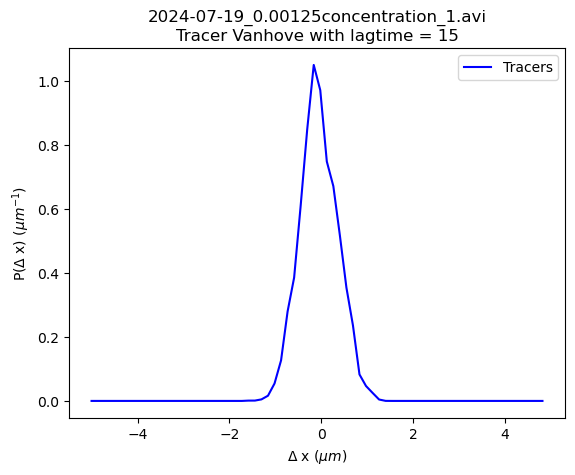

In [45]:
## reorder tracks by frame number
if doing_fueled:
    tracksbyframe_fueled_tracer = fueled_tracer_nodrift.set_index(['frame','particle'])['x'].unstack()
if doing_control:
    tracksbyframe_control_tracer = control_tracer_nodrift.set_index(['frame','particle'])['x'].unstack()
binsequence=np.arange(-vanhove_max_x,vanhove_max_x,binwidth)
## This makes a histogram of how far the particles traveled
#    You can choose the lagtime
if doing_fueled:
    trackshist_fueled_tracer_lg6 = tp.motion.vanhove(tracksbyframe_fueled_tracer, lagtime = vanhove_lagtime, mpp =
    scaling,bins = binsequence, ensemble = True)
if doing_control:
    trackshist_control_tracer_lg6 = tp.motion.vanhove(tracksbyframe_control_tracer, lagtime = vanhove_lagtime, mpp =
    scaling,bins = binsequence, ensemble = True)

if doing_fueled:
    trackshist_fueled_tracer_lg6_norm = manualnorm(trackshist_fueled_tracer_lg6)
if doing_control:
    trackshist_control_tracer_lg6_norm = manualnorm(trackshist_control_tracer_lg6)
if doing_fueled:
    trackshist_fueled_tracer_lg6_norm.plot(color = 'red', label="Tracers with fuel")
if doing_control:
    trackshist_control_tracer_lg6_norm.plot(color = 'blue', label="Tracers")
plt.title(movie_name + '\nTracer Vanhove with lagtime = ' + str(vanhove_lagtime))
plt.ylabel('P($\Delta$ x) ($\mu m^{-1}$)')
plt.xlabel('$\Delta$ x ($\mu m$)');
plt.legend()

In [46]:
if colorseparation:
    ## reorder tracks by frame number
    if doing_fueled:
        tracksbyframe_fueled_janus = fueled_janus_nodrift.set_index(['frame','particle'])['x'].unstack()
    if doing_control:
        tracksbyframe_control_janus = control_janus_nodrift.set_index(['frame','particle'])['x'].unstack()
    binsequence=np.arange(-vanhove_max_x,vanhove_max_x,binwidth)
    ## This makes a histogram of how far the particles traveled
    #    You can choose the lagtime
    if doing_fueled:
        trackshist_fueled_janus_lg6 = tp.motion.vanhove(tracksbyframe_fueled_janus, lagtime = vanhove_lagtime, mpp =
        scaling,bins = binsequence, ensemble = True)
    if doing_control:
        trackshist_control_janus_lg6 = tp.motion.vanhove(tracksbyframe_control_janus, lagtime = vanhove_lagtime, mpp =
        scaling,bins = binsequence, ensemble = True)
        
        
    if doing_fueled:
        trackshist_fueled_janus_lg6_norm = manualnorm(trackshist_fueled_janus_lg6)
    if doing_control:
        trackshist_control_janus_lg6_norm = manualnorm(trackshist_control_janus_lg6)
    if doing_fueled:
        trackshist_fueled_janus_lg6_norm.plot(color = 'red')
    if doing_control:
        trackshist_control_janus_lg6_norm.plot(color = 'blue')
    plt.title(movie_name + '\nJanus Vanhove with lagtime = ' + str(vanhove_lagtime)
              + ' frames\nRed = Fueled, Blue = Control')

    plt.legend()
    plt.ylabel('P($\Delta$ x) ($\mu m^{-1}$)')
    plt.xlabel('$\Delta$ x ($\mu$m)');

In [47]:
# Curve fit a Gaussian to the Vanhoves
if doing_fueled:
    fueled_janus_params, fueled_janus_covm = sco.curve_fit(gaussian, trackshist_fueled_janus_lg6_norm.index,
                                                          trackshist_fueled_janus_lg6_norm.values)
    fueled_janus_yfit = gaussian(trackshist_fueled_janus_lg6_norm.index, fueled_janus_params[0],
                                 fueled_janus_params[1], fueled_janus_params[2])

    trackshist_fueled_janus_lg6_norm.plot(style = 'r.')
    plt.plot(trackshist_fueled_janus_lg6_norm.index, fueled_janus_yfit, color = 'b')

    plt.yscale('log')
    plt.title(movie_name + '\nFueled Janus Vanhove with lagtime = ' + str(vanhove_lagtime) + ' frames,\nwith Gaussian fit')
    plt.legend()
    plt.ylabel('P($\Delta$ x) ($\mu m^{-1}$)')
    plt.xlabel('$\Delta$ x ($\mu m$)')

    # If you want to change the x and y limits:
    # ylim(ymin=0.00003, ymax=10)
    xlim(-vanhove_max_x,vanhove_max_x)

In [48]:
# Curve fit a Gaussian to the Vanhoves
if doing_fueled:
    fueled_tracer_params, fueled_tracer_covm = sco.curve_fit(gaussian, trackshist_fueled_tracer_lg6_norm.index,
                                                          trackshist_fueled_tracer_lg6_norm.values)
    fueled_tracer_yfit = gaussian(trackshist_fueled_tracer_lg6_norm.index, fueled_tracer_params[0],
                                 fueled_tracer_params[1], fueled_tracer_params[2])

    trackshist_fueled_tracer_lg6_norm.plot(style = 'r.')
    plt.plot(trackshist_fueled_tracer_lg6_norm.index, fueled_tracer_yfit, color = 'b')

    plt.yscale('log')
    plt.title(movie_name + '\nFueled Tracer Vanhove with lagtime = ' + str(vanhove_lagtime) + ' frames,\nwith Gaussian fit')
    plt.legend()
    plt.ylabel('P($\Delta$ x) ($\mu m^{-1}$)')
    plt.xlabel('$\Delta$ x ($\mu m$)')

In [49]:
# Curve fit a Gaussian to the Vanhoves
if doing_control and colorseparation:
    control_janus_params, control_janus_covm = sco.curve_fit(gaussian, trackshist_control_janus_lg6_norm.index,
                                                                trackshist_control_janus_lg6_norm.values)
    control_janus_yfit = gaussian(trackshist_control_janus_lg6_norm.index, control_janus_params[0],
                                   control_janus_params[1], control_janus_params[2])

    trackshist_control_janus_lg6_norm.plot(style = 'r.', label = 'Janus')
    plt.plot(trackshist_control_janus_lg6_norm.index, control_janus_yfit, color = 'b', label = 'fit' )

    plt.yscale('log')
    plt.title(movie_name + '\nControl Janus Vanhove with lagtime = ' + str(vanhove_lagtime) + ' frames,\nwith Gaussian fit')
    plt.legend()
    plt.ylabel('P($\Delta$ x) (micron)$^{-1}$')
    plt.xlabel('$\Delta$ x (micron)')
    plt.ylim(ymin = 1e-5)

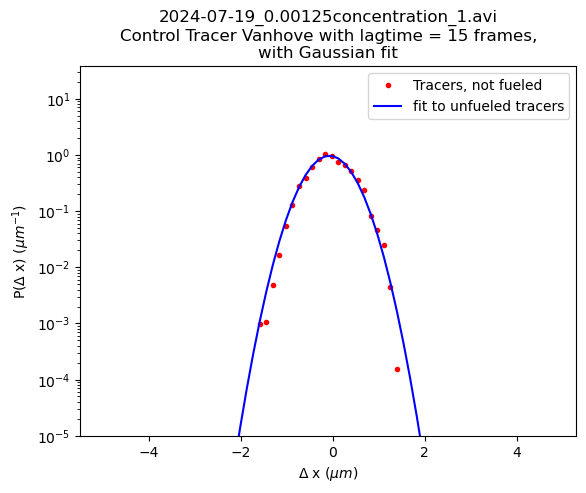

In [50]:
# Curve fit a Gaussian to the Vanhoves
if doing_control:
    control_tracer_params, control_tracer_covm = sco.curve_fit(gaussian, trackshist_control_tracer_lg6_norm.index,
                                                          trackshist_control_tracer_lg6_norm.values)
    control_tracer_yfit = gaussian(trackshist_control_tracer_lg6_norm.index, control_tracer_params[0],
                                 control_tracer_params[1], control_tracer_params[2])

    trackshist_control_tracer_lg6_norm.plot(style = 'r.', label="Tracers, not fueled")
    plt.plot(trackshist_control_tracer_lg6_norm.index, control_tracer_yfit, color = 'b', label="fit to unfueled tracers")

    plt.yscale('log')
    plt.title(movie_name + '\nControl Tracer Vanhove with lagtime = ' + str(vanhove_lagtime) + ' frames,\nwith Gaussian fit')
    plt.legend()
    plt.ylabel('P($\Delta$ x) ($\mu m^{-1}$)')
    plt.xlabel('$\Delta$ x ($\mu m$)')
    plt.ylim(ymin = 1e-5)

(1e-06, 38.14372320875676)

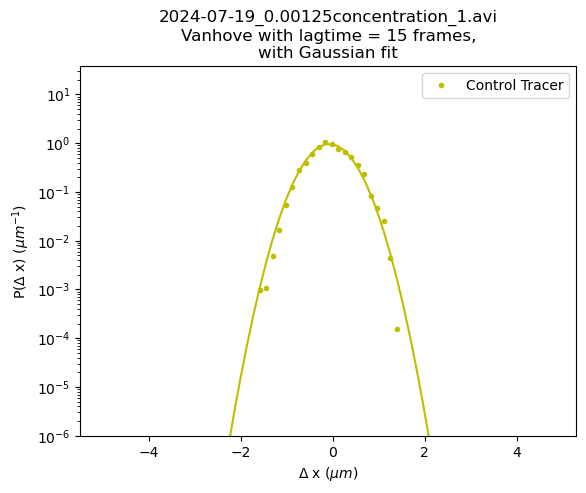

In [51]:
if colorseparation:
    if doing_fueled:
        trackshist_fueled_janus_lg6_norm.plot(style = 'r.', label = 'Fueled Janus')
        plt.plot(trackshist_fueled_janus_lg6_norm.index, fueled_janus_yfit, color = 'r')
    if doing_control:
        trackshist_control_janus_lg6_norm.plot(style = 'b.', label = 'Control Janus')
        plt.plot(trackshist_control_janus_lg6_norm.index, control_janus_yfit, color = 'b')
if doing_fueled:
    trackshist_fueled_tracer_lg6_norm.plot(style = 'g.', label = 'Fueled Tracer')
    plt.plot(trackshist_fueled_tracer_lg6_norm.index, fueled_tracer_yfit, color = 'g')
if doing_control:
    trackshist_control_tracer_lg6_norm.plot(style = 'y.', label = 'Control Tracer')
    plt.plot(trackshist_control_tracer_lg6_norm.index, control_tracer_yfit, color = 'y')

plt.yscale('log')
plt.title(movie_name + '\nVanhove with lagtime = ' + str(vanhove_lagtime) + ' frames,\nwith Gaussian fit')
plt.legend()
plt.ylabel('P($\Delta$ x) ($\mu m^{-1}$)')
plt.xlabel('$\Delta$ x ($\mu m$)')
plt.ylim(ymin=1e-6)

In [52]:
print('EXCESS KURTOSIS')
if doing_fueled:
    print('Fueled Janus: ' + str(trackshist_fueled_janus_lg6_norm.kurtosis()))
    metric3_fueled_janus = str(trackshist_fueled_janus_lg6_norm.kurtosis())
    print('Fueled Tracer: ' + str(trackshist_fueled_tracer_lg6_norm.kurtosis()))
    metric3_fueled_tracer = str(trackshist_fueled_tracer_lg6_norm.kurtosis())
if doing_control:
    if colorseparation:
        print('Control Janus: ' + str(trackshist_control_janus_lg6_norm.kurtosis()))
        metric3_control_janus = str(trackshist_control_janus_lg6_norm.kurtosis())
    print('Control Tracer: ' + str(trackshist_control_tracer_lg6_norm.kurtosis()))
    metric3_control_tracer = str(trackshist_control_tracer_lg6_norm.kurtosis())

EXCESS KURTOSIS
Control Tracer: 6.052275375654163


# Display summary numbers for spreadsheet

In [53]:
if colorseparation:
    if doing_fueled:
        print("fueled janus n: {0}".format(fueled_janus_fit.values[0,0]))
        print("fueled janus A: {0}".format(fueled_janus_fit.values[0,1]))
        print("fueled janus EXCESS KURTOSIS: {0}".format(str(metric3_fueled_janus)))
        print("fueled janus NUMBER OF PARTICLES AFTER FILTERING: {0}".format(metric4_fueled_janus))
    if doing_control:
        print("control janus n: {0}".format(control_janus_fit.values[0,0]))
        print("control janus A: {0}".format(control_janus_fit.values[0,1]))
        print("control janus EXCESS KURTOSIS: {0}".format(str(metric3_control_janus)))
        print("control janus NUMBER OF PARTICLES AFTER FILTERING: {0}".format(metric4_control_janus))

if doing_fueled:
    print("fueled tracer n: {0}".format(fueled_tracer_fit.values[0,0]))
    print("fueled tracer A: {0}".format(fueled_tracer_fit.values[0,1]))
    print("fueled tracer EXCESS KURTOSIS: {0}".format(str(metric3_fueled_tracer)))
    print("fueled tracer NUMBER OF PARTICLES AFTER FILTERING: {0}".format(metric4_fueled_tracer))
if doing_control:
    print("control tracer n: {0}".format(control_tracer_fit.values[0,0]))
    print("control tracer A: {0}".format(control_tracer_fit.values[0,1]))
    print("control tracer EXCESS KURTOSIS: {0}".format(str(metric3_control_tracer)))
    print("control tracer NUMBER OF PARTICLES AFTER FILTERING: {0}".format(metric4_control_tracer))
    print("control tracer MAXIMUM DRIFT (um):", max_cartesian_drift_control_tracer_um)

control tracer n: 1.0649643949612195
control tracer A: 1.2660023868720087
control tracer EXCESS KURTOSIS: 6.052275375654163
control tracer NUMBER OF PARTICLES AFTER FILTERING: 358
control tracer MAXIMUM DRIFT (um): 3.833026179875665


# Observe tracked trajectories

In [ ]:
### This section is for making the movie trajectories. 
# These serve two essential purposes:
# (1) Convincing us that we tracked the particles. 
# (2) Convincing other people that we tracked the particles.

# Assumes all videos have the same pixel length and width
if doing_control:
    (y_size,x_size) = control_green[0].shape
else:
    (y_size,x_size) = fueled_green[0].shape

new_movie_fps = 15   # doesn't have to be the same as fps
trajectory_folder = os.path.join(home, 'Trajectory')
movie_trajectory_folder = os.path.join(trajectory_folder, today, movie_name)

if (not os.path.exists(trajectory_folder)):
    os.makedirs(trajectory_folder)
    print("Created " + trajectory_folder)
if (not os.path.exists(os.path.join(trajectory_folder, today))):
    os.makedirs(os.path.join(trajectory_folder, today))
    print("Created " + os.path.join(trajectory_folder, today))
if (not os.path.exists(movie_trajectory_folder)):
    os.makedirs(movie_trajectory_folder)
    print("Created " + movie_trajectory_folder)
    
gc.collect();

In [ ]:
## Set constants

## Aesthetics
scalebar_greyscale = '0.5' # a higher number is more white. Choose something that contrasts with your movie.
scalebar_transparency = 0.75
trajectory_transparency = 0.4  ## 0 is completely transparent and 1 is completely opaque
particle_transparency = 0.2

fontsz=30

## Placement
scalebar_length_um = 15 # in microns
vertical_separation = 300
horizontal_separation = 50 # from left edge of movie to scalebar
text_bar_separation = 25
approx_length_of_text_px = 85
scalebar_height = 20
scalebar_bottom = x_size - vertical_separation
scalebar_top = scalebar_bottom - scalebar_height
scalebar_length_px = scalebar_length_um/scaling
scalebar_left_px = 0 + horizontal_separation              #scalebar_right_px - scalebar_length_px
scalebar_right_px = scalebar_left_px + scalebar_length_px #y_size-horizontal_separation
scalebar_left_percent = scalebar_left_px/(x_size*1.0)
#scalebar_length_percent = scalebar_length_px/(x_size*1.0)
#xmax = scalebar_length_percent + scalebar_left_percent
xmax = scalebar_right_px /(x_size*1.0)
center_of_bar = (scalebar_left_px + scalebar_right_px)/2.0
dpi = 72   # probably doesn't matter what this number is

frametime_sec = frametime/1000.0
moviegain=3

"""
Opens raw data frames from the disk, puts overlay over it,
writes new TIFF to disk. Memory semi-efficient :)

@param video_string - 'fueled' or 'control', tells function which TIFFs to open
@param name - filename of saved images
@param gain - multiply RGB values to better resolve particles from trajectories

@return None
"""
def make_movie_images_with_two_colors_new(video_string, name, gain=moviegain):
    green_particles, red_particles = (fueled_janus if video_string == 'fueled' else control_janus), (fueled_tracer if video_string == 'fueled' else control_tracer)
    green_tracks_to_show, red_tracks_to_show = green_particles['particle'].astype(int).unique(), red_particles['particle'].astype(int).unique()

   
    #length = len(os.listdir(movie_data_folder))
    frameno = 0
    
    for frame in sorted([item for item in np.sort(os.listdir(movie_data_folder)) if item.startswith(video_string)]):
        i = 0
        temp0 = tifffile.imread(os.path.join(movie_data_folder, frame))
        while i < len(temp0):
            #print(i)
            temp = temp0[i]
            #print(temp.shape)
            imagewidth=temp.shape[1]/dpi # calculate image width in inches
            imageheight=imagewidth*(temp.shape[0]/temp.shape[1])
            #print(imagewidth, imageheight)
            trajectorymovieframesize=[imagewidth,imageheight]

            fig = plt.figure(figsize=trajectorymovieframesize, frameon=False)
            #print(temp)
            ax = fig.add_axes([0,0,1,1])

            implot = ax.imshow(gain*temp)

            green_traj_hist = green_particles[green_particles.frame <= frameno]

            for this_particle in green_tracks_to_show:
                this_traj_hist = green_traj_hist[green_traj_hist.particle == this_particle]
                this_xcoords_hist = this_traj_hist['x']
                this_ycoords_hist = this_traj_hist['y']
                plot(this_xcoords_hist.values,this_ycoords_hist.values, 'g-', alpha=trajectory_transparency)

            #thisframefavcoords = green_particles[green_particles.frame == frameno]
            #xcoords, ycoords = thisframefavcoords['x'], thisframefavcoords['y']
            #plot(plt.xcoords.values, ycoords.values, 'r.', alpha=particle_transparency)
            
            red_traj_hist = red_particles[red_particles.frame <= frameno]
            
            for this_particle in red_tracks_to_show:
                this_traj_hist = red_traj_hist[red_traj_hist.particle == this_particle]
                this_xcoords_hist = this_traj_hist['x']
                this_ycoords_hist = this_traj_hist['y']
                plot(this_xcoords_hist.values,this_ycoords_hist.values, 'r-', alpha=trajectory_transparency)

            #thisframefavcoords = red_particles[green_particles.frame == frameno]
            #xcoords, ycoords = thisframefavcoords['x'], thisframefavcoords['y']
            #plot(plt.xcoords.values, ycoords.values, 'r.', alpha=particle_transparency)

            # scalebar
            plt.axhspan(scalebar_top, 
                    scalebar_top + scalebar_height, 
                    xmin=scalebar_left_percent, 
                    xmax=xmax,
                    color=scalebar_greyscale, 
                    alpha=scalebar_transparency)

            # scalebar label
            plt.text(center_of_bar-approx_length_of_text_px/2,scalebar_top-text_bar_separation, 
                 str(scalebar_length_um) + u' \u03bcm',
                 fontsize=fontsz,
                 color=scalebar_greyscale)

            # time stamp
            plt.text(horizontal_separation, horizontal_separation, "{:.1f}".format(frameno*frametime_sec) + ' sec',
                 fontsize=fontsz,
                 color=scalebar_greyscale)

            plt.ylim(y_size,0)
            plt.xlim(0,x_size)
            plt.xticks([],'')
            plt.yticks([],'')

            savefigure(name + '_' + str(frameno).zfill(4))       

            temp0[i] = 0
            del temp
            i += 1
            frameno += 1
            
            close()
            
        
        del temp0
        gc.collect()

In [ ]:
""" 
Overlays only one group of particle trajectories over a TIFF and writes to disk.

@param particles - the pandas dataframe of particle trajectories
@param frames - the TIFF stack of particle motion
@param name - the name of the images being written on the disk
@param gain - multiply RGB values to better resolve particles from trajectories

@return None
"""
def make_movie_images_with_one_color(particles, frames, name, gain=1):
    tracks_to_show = particles['particle'].astype(int).unique()

    # Calculate image width and height in inches.
    imagewidth=frames.shape[2]/dpi # calculate image width in inches
    imageheight=imagewidth*(frames.shape[1]/frames.shape[2])
    trajectorymovieframesize=[imagewidth,imageheight]
    
    # Thanks to Becca Perry for helping me with this code.
    for i in range(len(frames)): 
        #print(i)
        fig = plt.figure(figsize=trajectorymovieframesize,frameon=False)
        ax = fig.add_axes([0,0,1,1])

        implot = ax.imshow(gain*frames[i])

        traj_hist =  particles[particles.frame <=i]

        for this_particle in tracks_to_show:
            this_traj_hist = traj_hist[traj_hist.particle == this_particle]
            this_xcoords_hist = this_traj_hist['x']
            this_ycoords_hist = this_traj_hist['y']
            plt.plot(this_xcoords_hist.values,this_ycoords_hist.values, 'r-', alpha=0.4)

        thisframefavcoords = particles[particles.frame ==i]
        plt.xcoords = thisframefavcoords['x']
        plt.ycoords = thisframefavcoords['y']
        plt.plot(plt.xcoords.values,plt.ycoords.values, 'r.', alpha=0.2)

        # scalebar
        plt.axhspan(scalebar_top, 
                scalebar_top + scalebar_height, 
                xmin=scalebar_left_percent, 
                xmax=xmax,
                color=scalebar_greyscale, 
                alpha=0.75)

        # scalebar label
        plt.text(center_of_bar-approx_length_of_text_px/2,scalebar_top-text_bar_separation, 
             str(scalebar_length_um) + u' \u03bcm',
             fontsize=fontsz,
             color=scalebar_greyscale)

        # time stamp
        plt.text(horizontal_separation, horizontal_separation, "{:.1f}".format(i*frametime_sec) + ' sec',
             fontsize=fontsz,
             color=scalebar_greyscale)

        plt.ylim(y_size,0)
        plt.xlim(0,x_size)
        plt.xticks([],'')
        plt.yticks([],'')

        savefigure(name + '_' + str(i).zfill(4))

        if i < len(frames)-1:
            plt.close() # close all images except the last one.
        if i % 10 == 0:
            gc.collect()
    print('Saved images to:', os.path.join(movie_trajectory_folder, name + '_' + str(i).zfill(4) +'.tif'));

In [ ]:
if doing_control:
    make_movie_images_with_one_color(particles = control_tracer,  frames=pims.Video(control_file), 
                                     name=movie_name, gain=1)
    

In [ ]:
if doing_fueled:
    make_movie_images_with_two_colors_new(video_string = 'fueled', name = 'fueled')

In [ ]:
if doing_control:
    make_movie_images_with_two_colors_new(video_string = 'control', name = 'control')    

In [ ]:
import cv2

using_tif = False


"""
Open the recently written TIFFs with overlay and stitch them into an .avi file.

@param name - 'fueled' vs 'control'; which images to read.
@return None
"""
def make_movie_video(name):
    os.chdir(movie_trajectory_folder)
    if using_tif:
        print('Looking in folder:', movie_trajectory_folder)
        images = [img for img in np.sort(os.listdir(movie_trajectory_folder)) if (img.startswith(name) and img.endswith('.tif'))]
        frame = cv2.imread(os.path.join(movie_trajectory_folder, images[0]))

    else:
        images = pims.Video(control_file)
        frame = images[0]
    height, width, layers = frame.shape

    video = cv2.VideoWriter(name + ".avi", 0, 15, (width, height))
    print('Saved:', str(name) + '.avi')

    
    for image in images:
        video.write(cv2.imread(os.path.join(movie_trajectory_folder, image)))
        #os.remove(os.path.join(movie_trajectory_folder, image))
    

    cv2.destroyAllWindows()
    video.release()

#Might only work with the .tif
if doing_fueled:
    make_movie_video(fueled_movie_filename)
if doing_control:
    make_movie_video(movie_name + '_CONTROL')

os.chdir(home)

In [ ]:
gc.collect()